In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
import warnings
import category_encoders as ce
import impyute
from impyute.imputation.cs import mice

from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

from sklearn.preprocessing import OrdinalEncoder, StandardScaler, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, log_loss, roc_curve

from collections import Counter


import time

pd.options.mode.chained_assignment = None

plt.style.use('bmh')

# 1. Exploratory Data Analysis (EDA)

In [4]:
df_orig = pd.read_csv("data/challenge3_train.csv")
df_orig.head(5)

,id,target,f0,f1,f2,f3,f4,f5,f6,f7,...,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30
0,0,1,0.0,5.0,0.0,4.0,3598.0,M,3.0,-7.2430,...,3.0,14.2364,0.0,NaN,4.0,1.0,5.0,PS,2.0,0.834041
1,1,0,NaN,5.0,4.0,NaN,2072.0,NaN,4.0,-1.6662,...,3.0,NaN,2.0,3.0,NaN,1.0,5.0,DT,5.0,0.686021
2,2,0,1.0,1.0,4.0,2.0,862.0,M,3.0,-0.1200,...,NaN,NaN,2.0,2.0,3.0,1.0,2.0,vq,5.0,1.141271
3,3,0,NaN,NaN,2.0,1.0,409.0,F,5.0,-16.2169,...,5.0,NaN,2.0,1.0,5.0,1.0,0.0,Bx,5.0,0.662382
4,4,1,NaN,5.0,0.0,3.0,222.0,NaN,5.0,-8.1088,...,5.0,13.9537,4.0,5.0,NaN,1.0,1.0,kB,5.0,-1.000000


We start by removing the 'id' and the 'target' columns, as the first is simply a unique ID for each row, and the second is the target variable. 

In [5]:
id_ = df_orig[['id']]
target = df_orig[['target']]
df_orig_with_target = df_orig.copy()
df_orig.drop(columns=['id', 'target'], inplace=True)
print(f'Data has {df_orig.shape[0]} rows, each with {df_orig.shape[1]} features.')
df_orig.head(10)
df_orig.head(5)

Data has 50000 rows, each with 31 features.


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30
0,0.0,5.0,0.0,4.0,3598.0,M,3.0,-7.2430,13.9681,3.0,...,3.0,14.2364,0.0,NaN,4.0,1.0,5.0,PS,2.0,0.834041
1,NaN,5.0,4.0,NaN,2072.0,NaN,4.0,-1.6662,14.0242,0.0,...,3.0,NaN,2.0,3.0,NaN,1.0,5.0,DT,5.0,0.686021
2,1.0,1.0,4.0,2.0,862.0,M,3.0,-0.1200,14.2174,0.0,...,NaN,NaN,2.0,2.0,3.0,1.0,2.0,vq,5.0,1.141271
3,NaN,NaN,2.0,1.0,409.0,F,5.0,-16.2169,13.8536,0.0,...,5.0,NaN,2.0,1.0,5.0,1.0,0.0,Bx,5.0,0.662382
4,NaN,5.0,0.0,3.0,222.0,NaN,5.0,-8.1088,14.2347,0.0,...,5.0,13.9537,4.0,5.0,NaN,1.0,1.0,kB,5.0,-1.000000


## 1.1 Missing values
First we check the distribution over missing values for the different features (columns). 

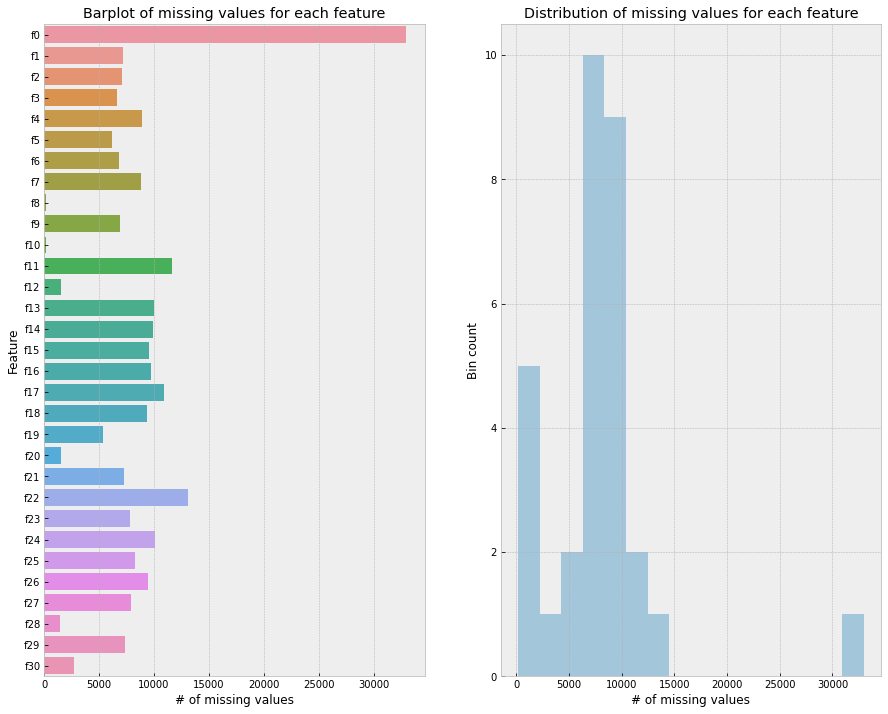

In [6]:
missing_values = df_orig.isna().sum()
fig, ax = plt.subplots(1,2, figsize=(15, 12))
sns.barplot(missing_values.values, missing_values.index, ax=ax[0])
ax[0].set_title("Barplot of missing values for each feature")
ax[0].set_xlabel('# of missing values')
ax[0].set_ylabel('Feature');

sns.distplot(missing_values.values, ax=ax[1], kde=False)
ax[1].set_title("Distribution of missing values for each feature")
ax[1].set_xlabel('# of missing values')
ax[1].set_ylabel('Bin count');


On the left we see a barplot over the number of missing values for each feature. We observe that the feature 'f0' has very many missing values, and that the rest is distributed between 0 to around 13000 missing values. The histogram on the right confirms this. We define a method that finds all features where the fraction of missing values is above a certain threshold.

In [7]:
def get_features_with_nan(df, thresh=0.3):
    df2 = df.copy()
    columns = [column for column in df2.columns if df2[column].isna().sum() / len(df2) >= thresh]
    # print(f'Dropped columns: {columns}')
    
    return columns

In [8]:
df = df_orig.copy()

In [9]:
drop_cols = get_features_with_nan(df_orig, thresh=0.3)
df.drop(columns=drop_cols, inplace=True)
df.head()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30
0,5.0,0.0,4.0,3598.0,M,3.0,-7.2430,13.9681,3.0,0.0,...,3.0,14.2364,0.0,NaN,4.0,1.0,5.0,PS,2.0,0.834041
1,5.0,4.0,NaN,2072.0,NaN,4.0,-1.6662,14.0242,0.0,0.0,...,3.0,NaN,2.0,3.0,NaN,1.0,5.0,DT,5.0,0.686021
2,1.0,4.0,2.0,862.0,M,3.0,-0.1200,14.2174,0.0,32.0,...,NaN,NaN,2.0,2.0,3.0,1.0,2.0,vq,5.0,1.141271
3,NaN,2.0,1.0,409.0,F,5.0,-16.2169,13.8536,0.0,0.0,...,5.0,NaN,2.0,1.0,5.0,1.0,0.0,Bx,5.0,0.662382
4,5.0,0.0,3.0,222.0,NaN,5.0,-8.1088,14.2347,0.0,0.0,...,5.0,13.9537,4.0,5.0,NaN,1.0,1.0,kB,5.0,-1.000000


There are still features with many missing values, which needs to be handled. Before we get to that, we explore the different feature types.

## 1.2 Feature types (continuous vs discrete)
We want to find which features are continuous and which are discrete. This is important because we want to fill in missing values differently depending on the variable is continuous or discrete. As an example, if a feature represented salary, it could make sense to impute missing values using the mean. But for a discrete feature, such as the number of cars a person owns, it does not make sense to impute using mean, as this will most likely result in persons having a 'illegal' (fractional) number of cars (1.3 cars, for instance). 

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 30 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      42852 non-null  float64
 1   f2      42885 non-null  float64
 2   f3      43352 non-null  float64
 3   f4      41089 non-null  float64
 4   f5      43792 non-null  object 
 5   f6      43176 non-null  float64
 6   f7      41138 non-null  float64
 7   f8      49855 non-null  float64
 8   f9      43135 non-null  float64
 9   f10     49840 non-null  float64
 10  f11     38383 non-null  float64
 11  f12     48487 non-null  object 
 12  f13     40023 non-null  float64
 13  f14     40132 non-null  float64
 14  f15     40430 non-null  object 
 15  f16     40238 non-null  float64
 16  f17     39102 non-null  float64
 17  f18     40592 non-null  float64
 18  f19     44658 non-null  float64
 19  f20     48488 non-null  object 
 20  f21     42717 non-null  float64
 21  f22     36888 non-null  float64
 22

From this we observe that we have mostly numerical values (float64), and some categorical non-numerical values (object). This divides the data into numeric and non-numeric features.

In [11]:
numerical_features = [c for c in df.columns if df[c].dtype == 'float64'] # df.select_dtypes('float64')# 
non_numerical_features = [c for c in df.columns if df[c].dtype == 'object']

In [12]:
print(f'Numerical features:\n{numerical_features} \n')
print(f'Categorical features:\n {non_numerical_features}')


Numerical features:
['f1', 'f2', 'f3', 'f4', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f13', 'f14', 'f16', 'f17', 'f18', 'f19', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f29', 'f30'] 

Categorical features:
 ['f5', 'f12', 'f15', 'f20', 'f28']


#### Non-numerical features
Let's check the distributions for each non-numerical feature. This is useful to know when we later will encode them into numerical values.

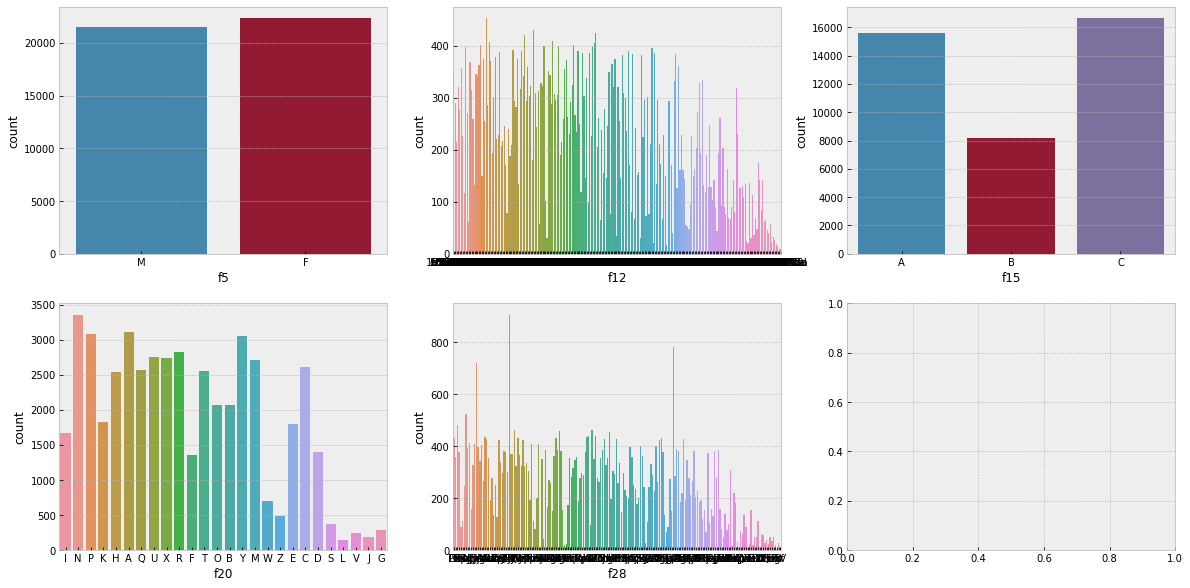

In [13]:
# sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})
fig, ax = plt.subplots(2, 3, figsize=(20, 10))
for variable, subplot in zip(non_numerical_features, ax.flatten()):
    sns.countplot(df[variable], ax=subplot)
    #for label in subplot.get_xticklabels():
     #   label.set_rotation(90)

In [14]:
print(f'f12 has {df["f12"].nunique()} unique values')
print(f'f28 has {df["f28"].nunique()} unique values')

f12 has 222 unique values
f28 has 190 unique values


In [15]:
df.drop(columns=['f12', 'f28'], inplace=True)

#### Numerical features
Let's check the distributions for each numerical feature.

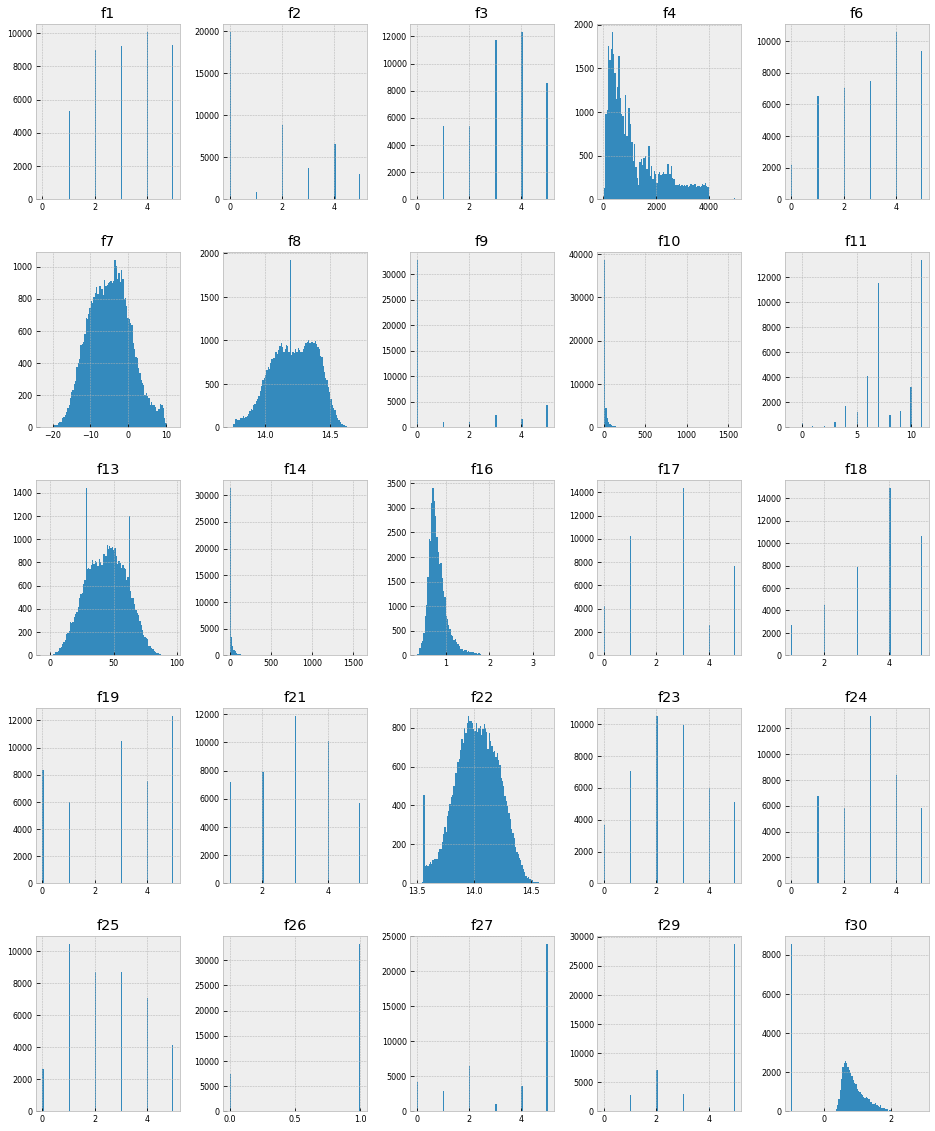

In [16]:
df[numerical_features].hist(figsize=(16, 20), bins=100, xlabelsize=8, ylabelsize=8);

From above it seems like only 9 of the numerical features are continuous (f4, f7, f8, f10, f13, f14, f16, f22 and f30). The rest can be threated as discrete features. These discrete features may or may not have a natural ordering of their values, that is, they can be ordinal or nominal. Because we do not have feature names available, it is hard to know which are ordinal and which are ordinal.  

We also observe that 'f30' has a lot of '-1' values, a number typically used to denote 'missing value'. Therefore we should converte these to NaNs. 
We also observe that some of the continuous features have very many zero values (f10, f14). It might be the case that the value zero is used to denote 'missing value' for these features (altough this is not so usual). However, we will make a method that will work on a particular column, and replace specific values with the NaN value. 

In [17]:
def replace_with(df, column, value, replace_value=np.nan):
    # print(f'[{column}] Replacing {value}s with {replace_value}')
    df2 = df.copy()
    df2[column] = df2[column].apply(lambda v: replace_value if v == value else v)
    return df2

In [18]:
df = replace_with(df, 'f30', -1)
df = replace_with(df, 'f10', 0)
#df = replace_with(df, 'f14', 0)

## 1.3 Correlations between numerical values 
It may be useful to look at the correlation between the numerical features. To do so we plot a heatmap and creates some methods for getting the top correlated features. 

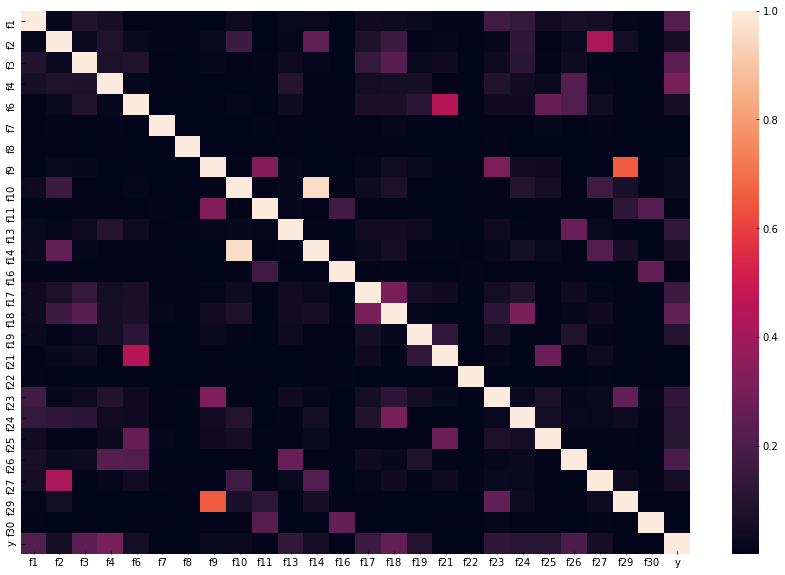

In [19]:
plt.figure(figsize=(15, 10))
num_cols = df.select_dtypes(exclude=['object']).columns
corr_df = df.copy()[num_cols]
corr_df['y'] = target
corr = corr_df.corr()
sns.heatmap(corr.abs(), 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values);

By inspecting the heatmap we observe that most features have a quite low correlation. However, f14 and f10 seems to have a very high correlation. Let's confirm this by looking at the numbers..

In [20]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

num_df = df.select_dtypes('float64')
print("Top Absolute Correlations")
print(get_top_abs_correlations(num_df, 5))

Top Absolute Correlations
f10  f14    0.961985
f9   f29    0.653525
f6   f21    0.443865
f2   f27    0.418460
f9   f11    0.334885
dtype: float64


As we see, f10 and f14 have a correlation of 0.967. We therefore choose to drop one of them. There are two reasons to why we choose to drop highly correlated features:
1. For linear models (e.g. logistic regression), multicolinearity can yield solutions that are wildly varying and possibly numerically unstable.
2. Tree-based models (e.g. decision tree, random forest) can be good at detecting interactions between different features, but highly correlated features can mask these interactions.

More generally, this can be viewed as a special case of Occam's razor. A simpler model is preferable [(1)](https://datascience.stackexchange.com/questions/24452/in-supervised-learning-why-is-it-bad-to-have-correlated-features).

In [21]:
print(f'f10 has {num_df["f10"].isna().sum()} nan values')
print(f'f14 has {num_df["f14"].isna().sum()} nan values')

f10 has 28145 nan values
f14 has 9868 nan values


We choose to drop f14 as it has quite many nan values, while f10 has almost no one. But first, because they are so highly correlated, we use f14 to impute nan values for f10.

In [22]:
df.drop(columns=['f14'], inplace=True)
numerical_features.remove('f14')


#### Splitting into discrete and continuous features

Now let's define a method that divides the features into continuous and discrete data. We treat features that have less than a certain threshold number of unique values as discrete, and the rest as continuous. 

In [23]:
def get_discrete_and_continuous_feature(df, threshold=300):
    df2 = df.copy()
    discrete_cols = [c for c in df2.columns if df2[c].nunique() <= threshold]
    cont_cols = [c for c in df2.columns if df2[c].nunique() > threshold]
    return discrete_cols, cont_cols
    

In [24]:
discrete_cols, cont_cols = get_discrete_and_continuous_feature(df)
print(f'Discrete features: {discrete_cols}')
print(f'Continuous features: {cont_cols}')

Discrete features: ['f1', 'f2', 'f3', 'f5', 'f6', 'f9', 'f11', 'f13', 'f15', 'f17', 'f18', 'f19', 'f20', 'f21', 'f23', 'f24', 'f25', 'f26', 'f27', 'f29']
Continuous features: ['f4', 'f7', 'f8', 'f10', 'f16', 'f22', 'f30']


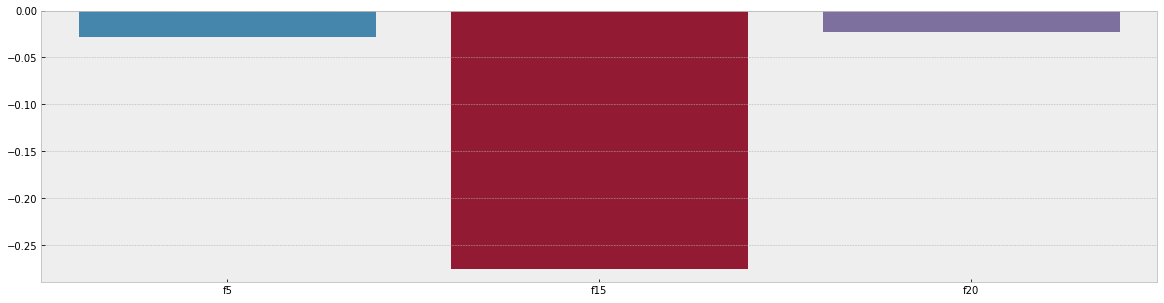

In [123]:
df_objects = df.dropna().select_dtypes(include='object')
df_corr = df_objects.copy()

for column in df_corr:
    df_corr[column] = df_corr[column].astype('category').cat.codes
    df_corr[column] = df_corr[column]/df_corr[column].max()

    
cleaned_corr = df_corr.corrwith(target["target"])
plt.figure(figsize=(20, 5))
sns.barplot(cleaned_corr.index, cleaned_corr.values)
plt.show()

<AxesSubplot:>

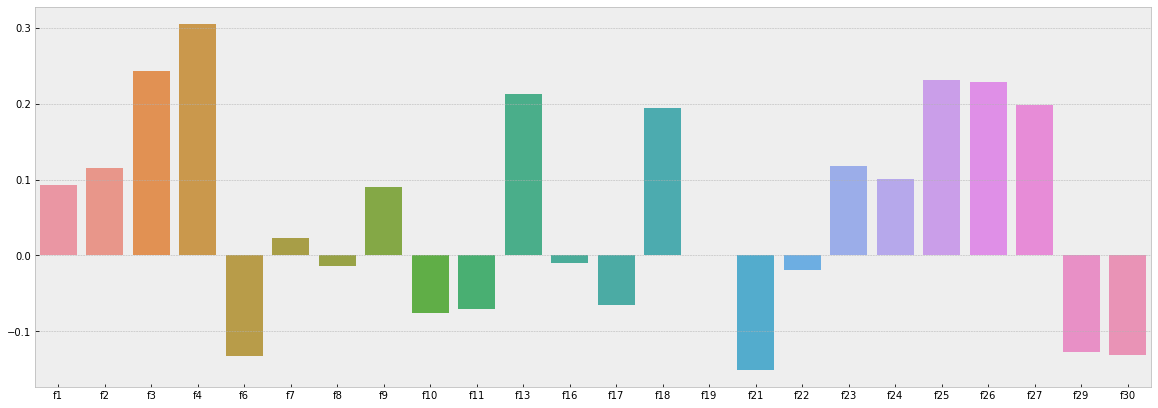

In [34]:
df_non_objects = df.dropna().select_dtypes(exclude='object')
df_corr_2 = df_non_objects.copy()

for column in df_corr_2:
    df_corr_2[column] = df_corr_2[column]/df_corr_2[column].max()

cleaned_corr_2 = df_corr_2.corrwith(target["target"])
plt.figure(figsize=(20, 7))
sns.barplot(cleaned_corr_2.index, cleaned_corr_2.values)


## 1.4 Target distribution across features

### Discrete features

First, let's see how the target's distribution looks like.

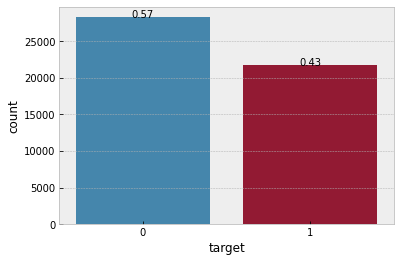

In [149]:
ax = sns.countplot(target['target'])
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 5,
            '{:1.2f}'.format((height/len(target))),
            ha="center")
plt.show()

As we can see there is a relatively even distribution between the target values, with 57% of the data being a 1, and 43% being 0.

Let's see how the features target distribution looks like.

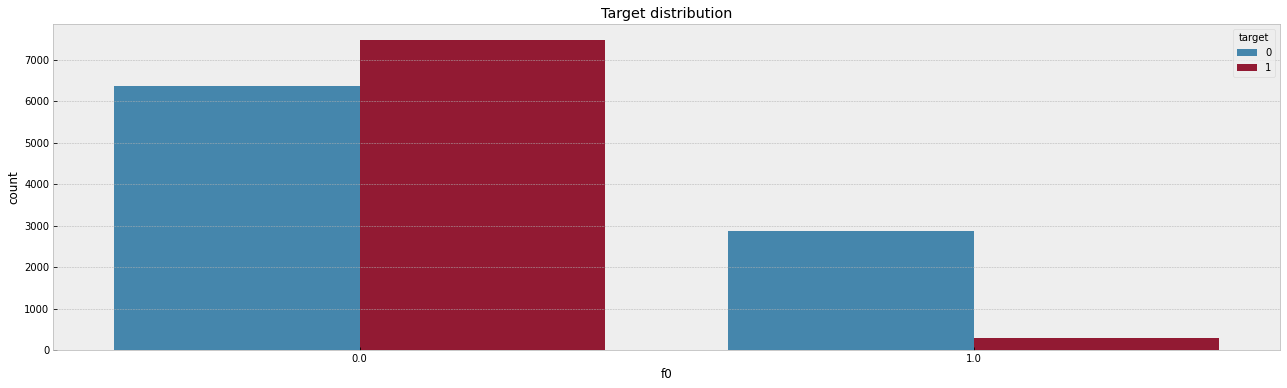

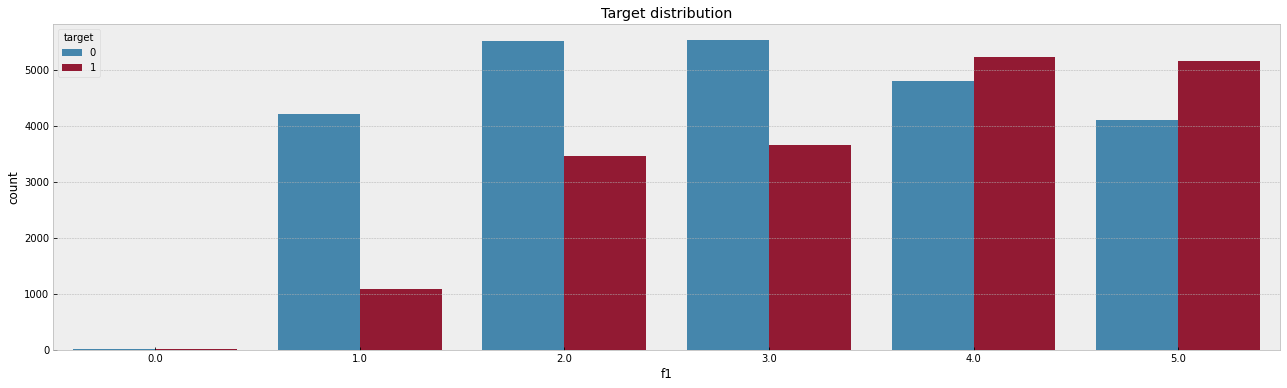

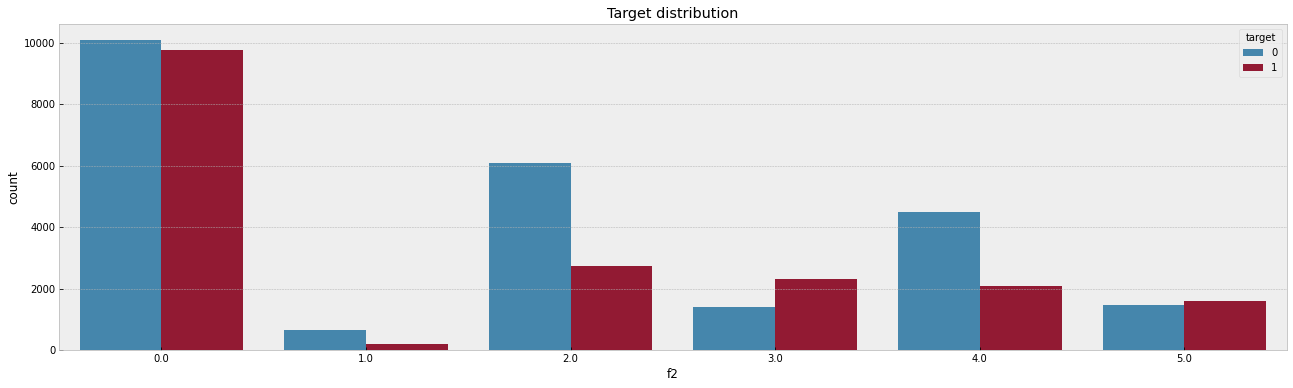

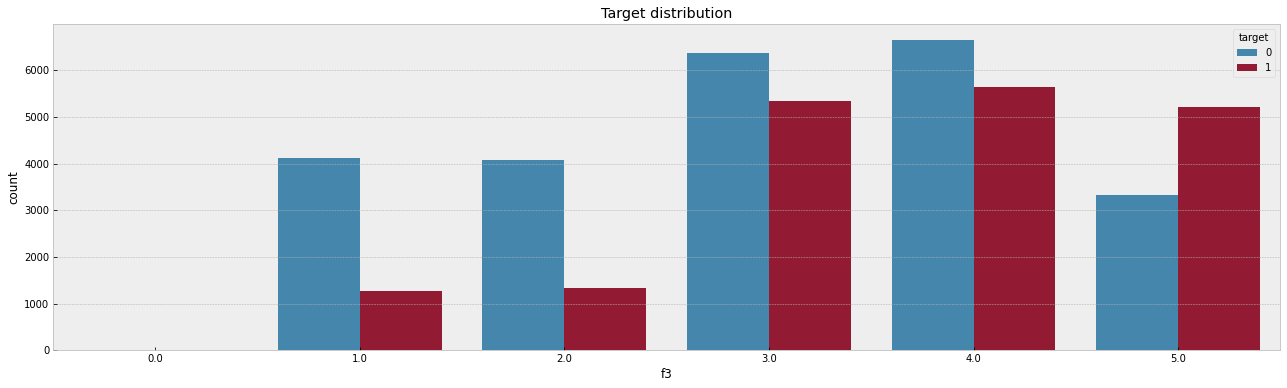

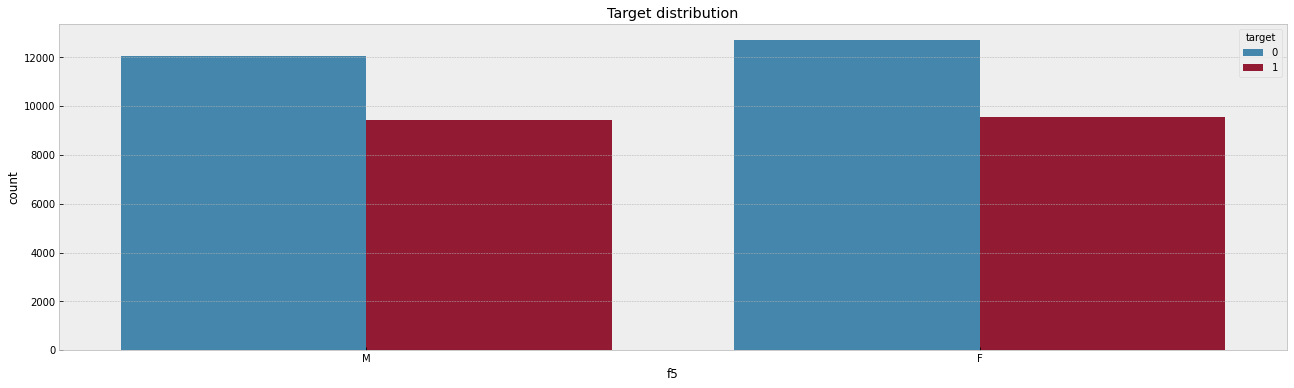

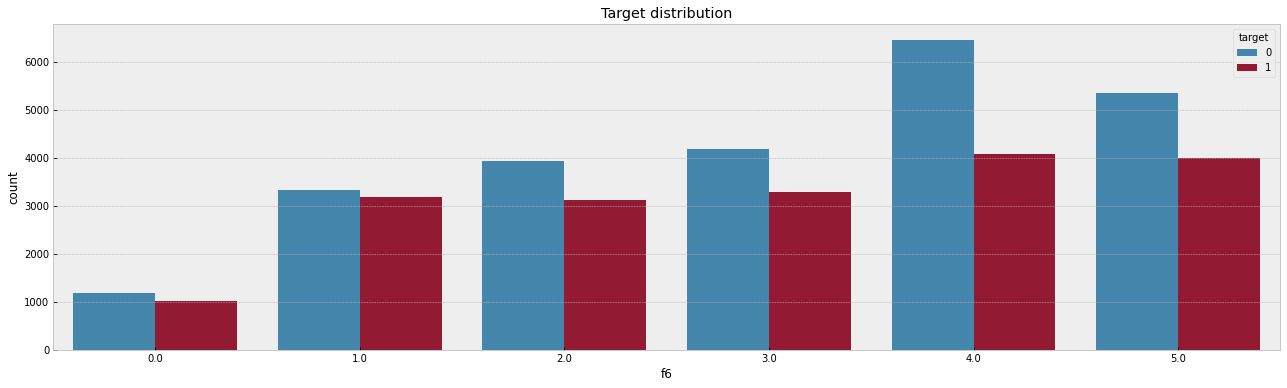

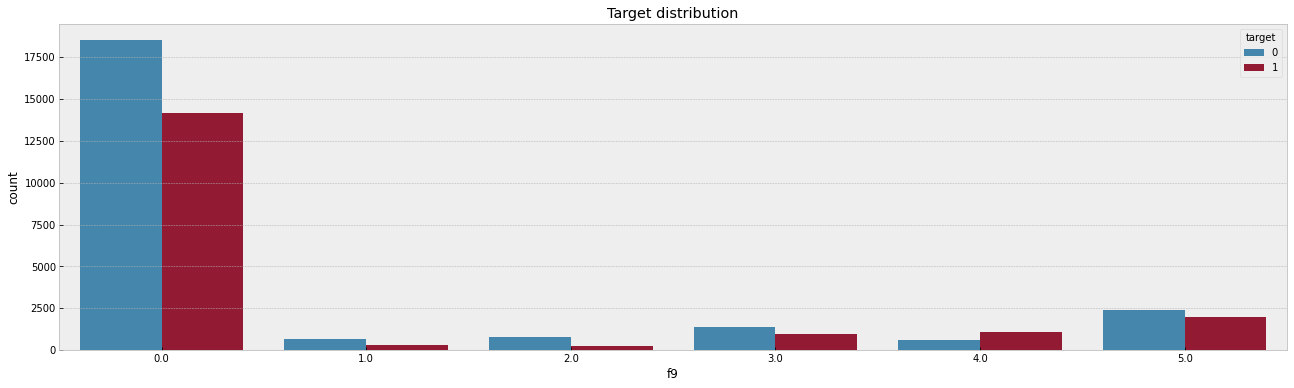

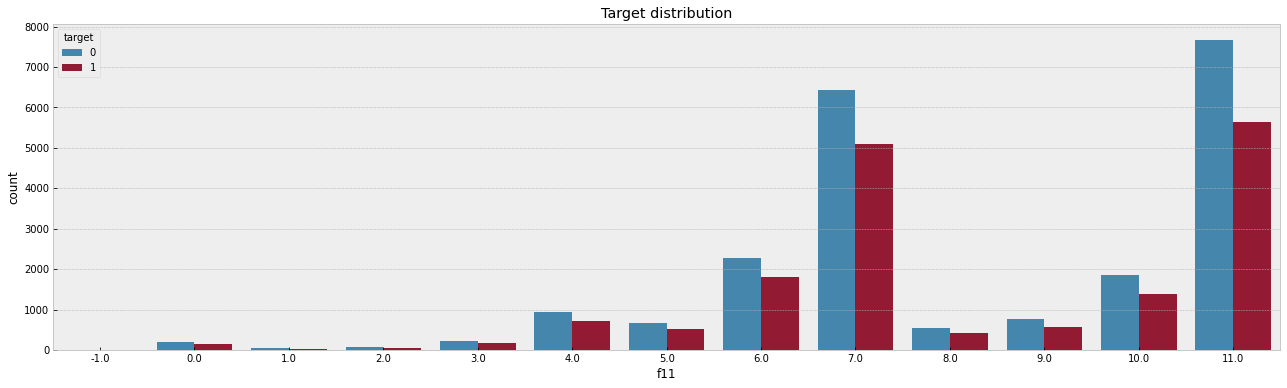

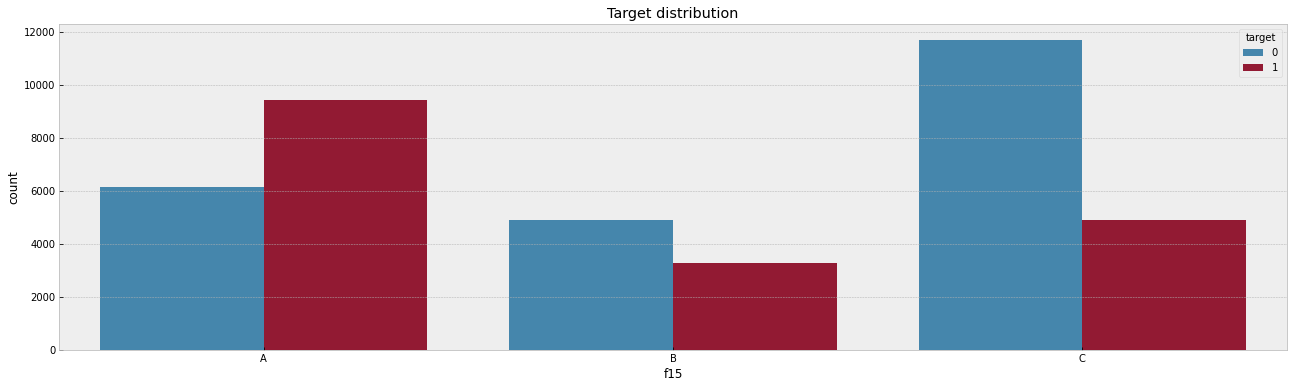

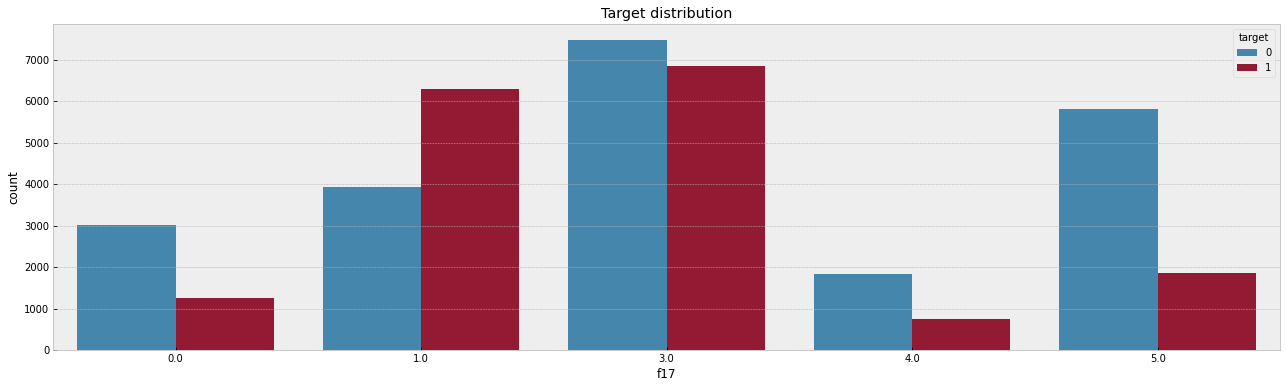

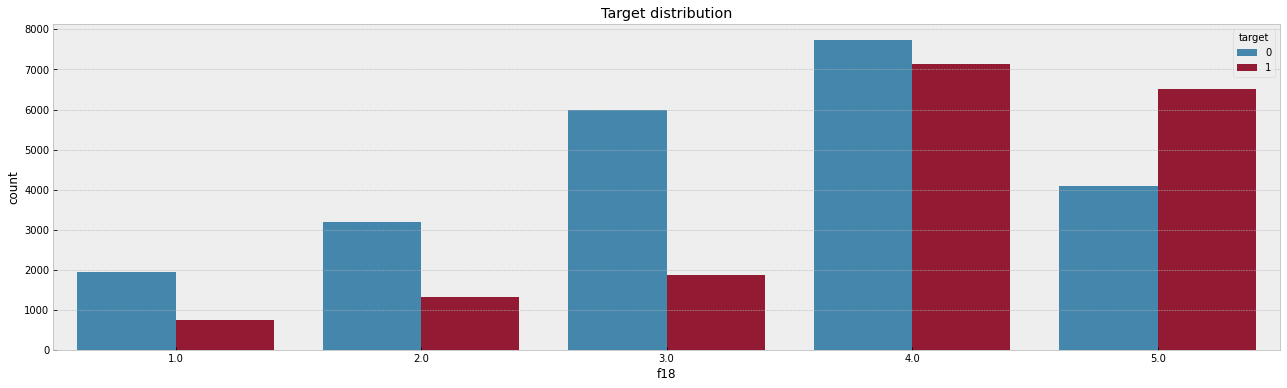

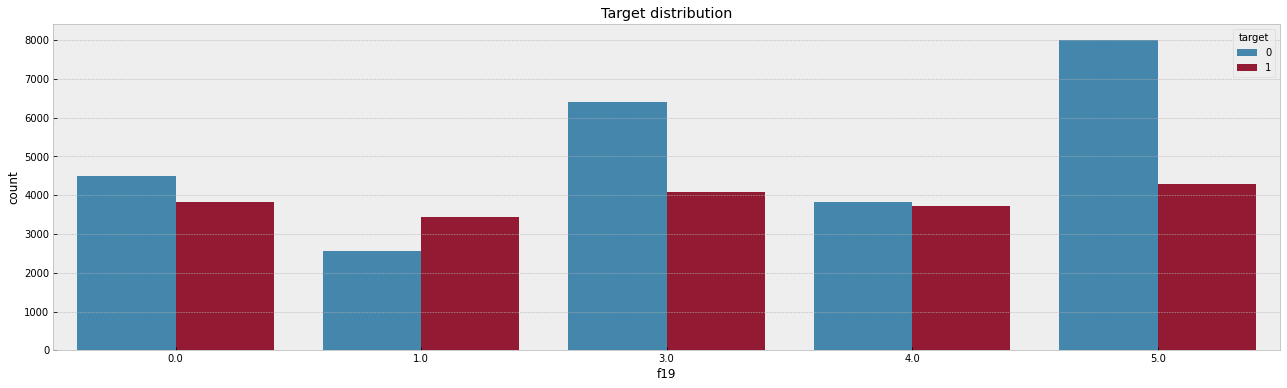

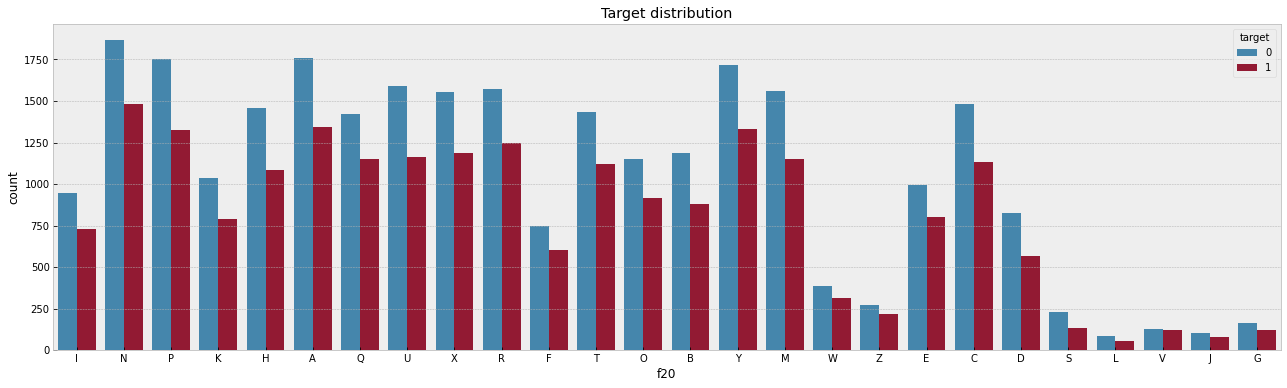

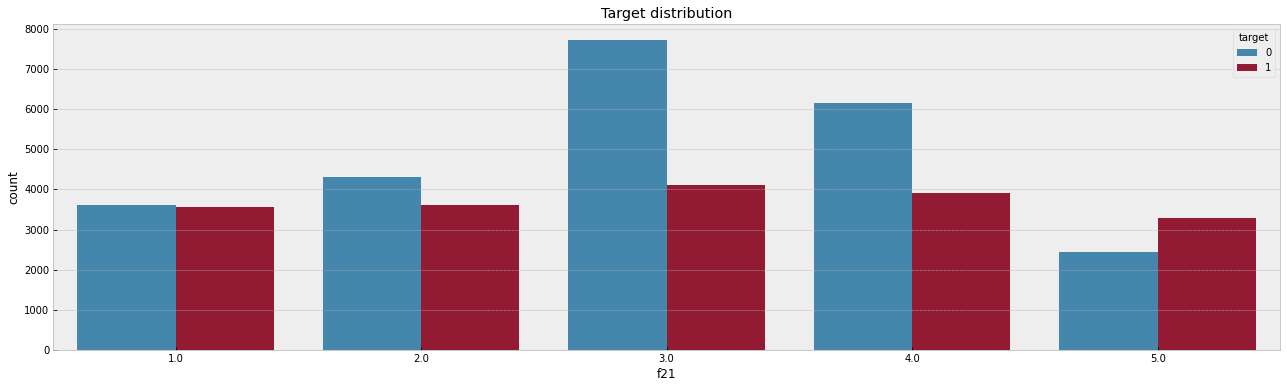

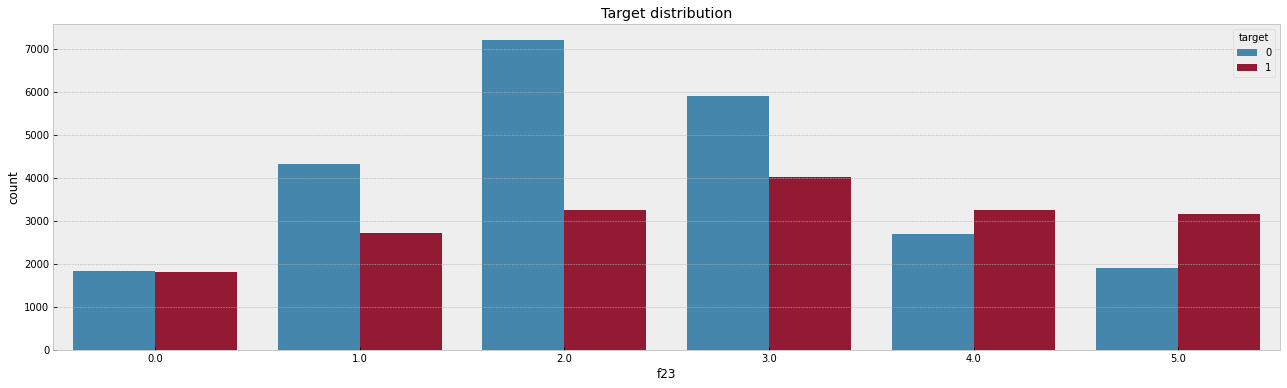

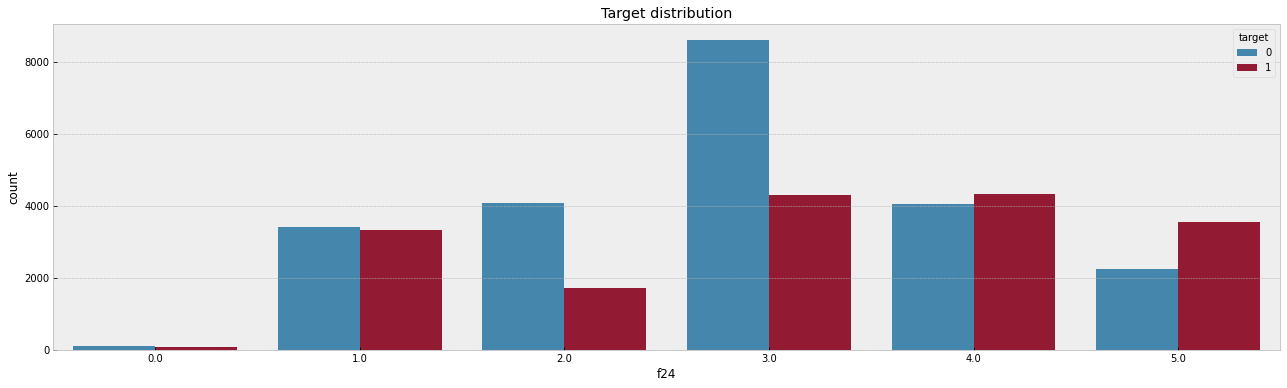

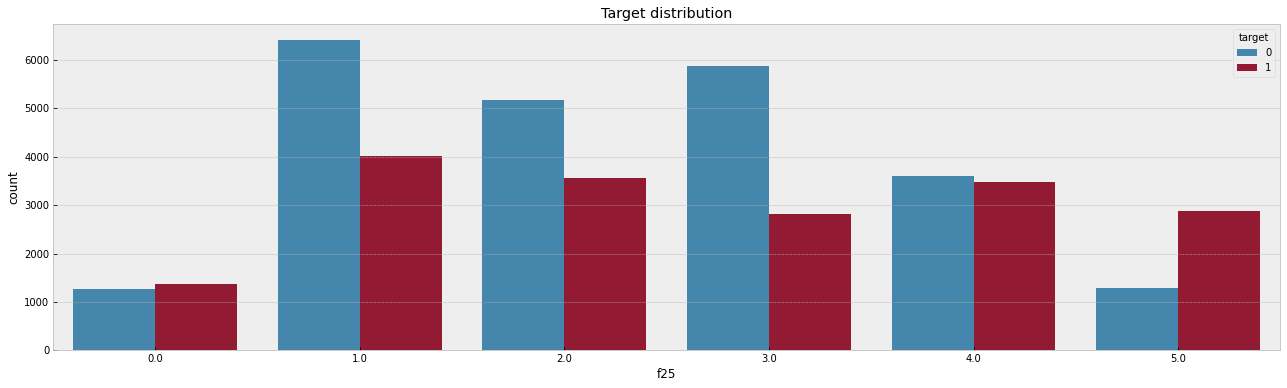

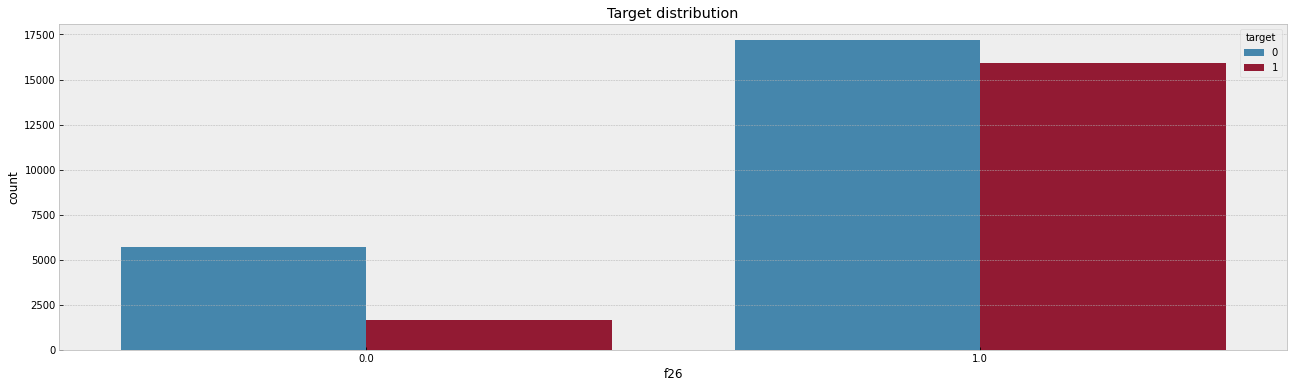

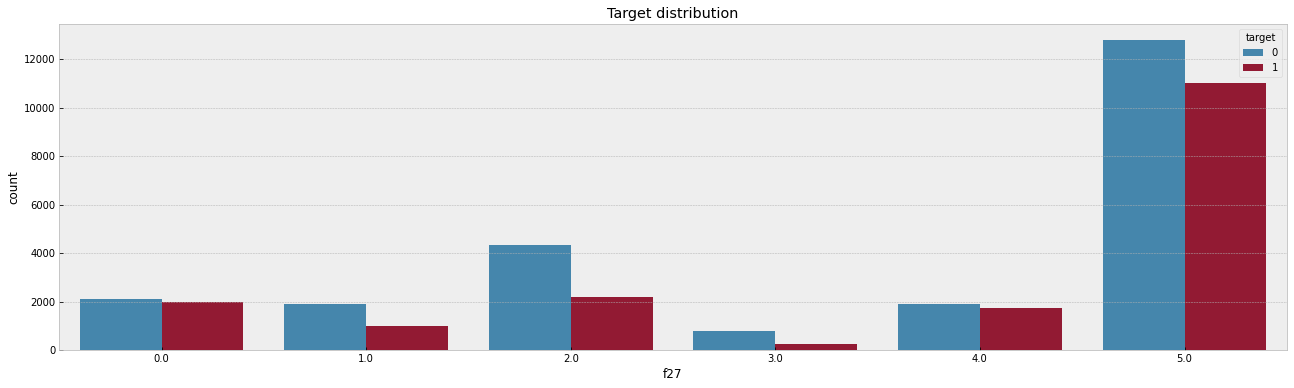

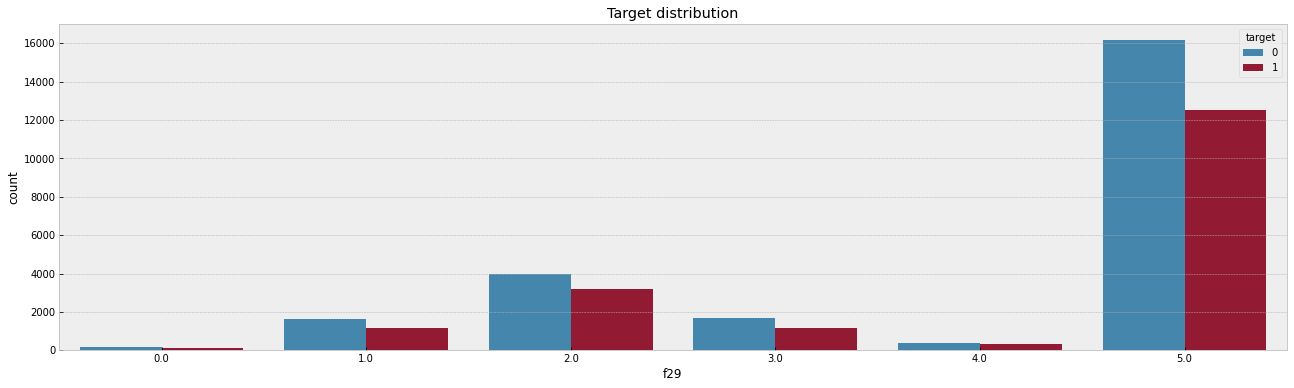

In [110]:
cols_to_ignore = ['f12', 'f13', 'f28'] 
discrete_cols_to_check = []
for col in discrete_cols:
    if col not in cols_to_ignore:
        discrete_cols_to_check.append(col)

for column in df_orig_with_target[discrete_cols_to_check]:
    plt.figure(figsize=(22,6))
    plt.title('Target distribution')
    ax = sns.countplot(df_orig_with_target[column], hue=df_orig_with_target.target)    
    plt.show()
    

### Continuos features 

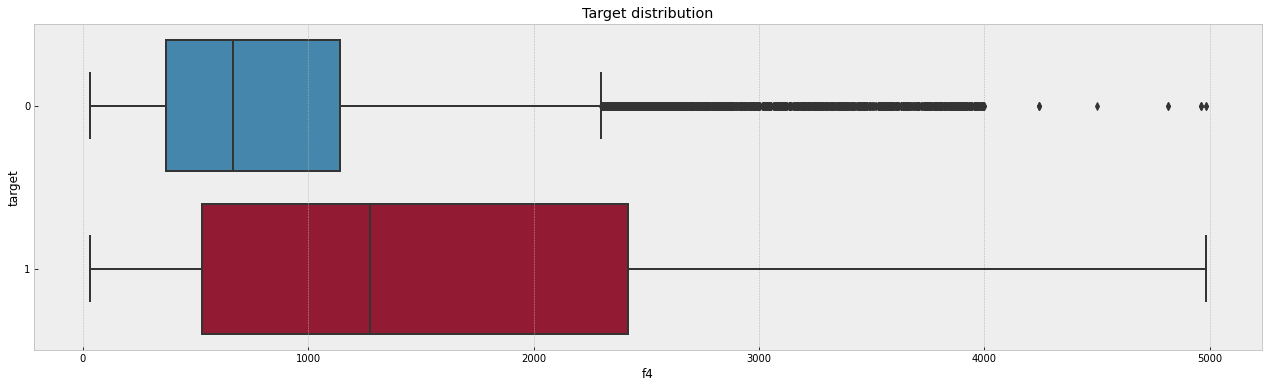

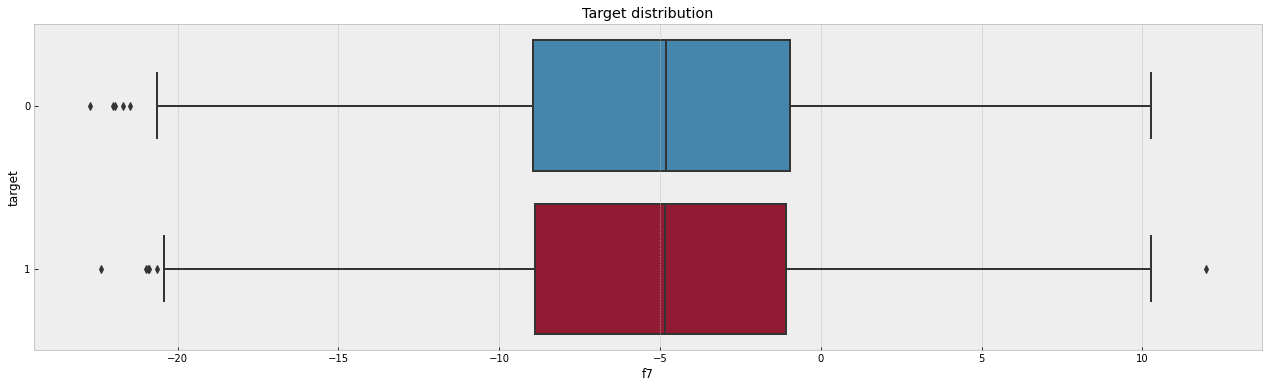

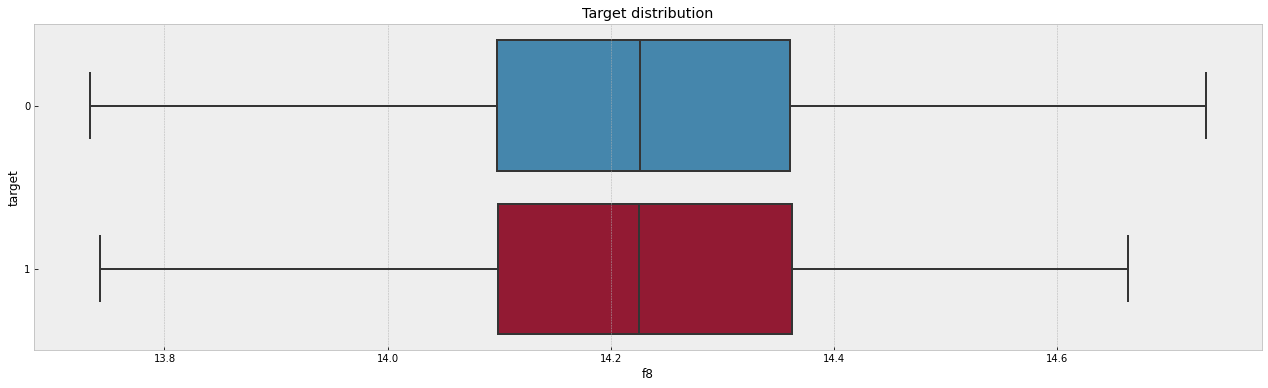

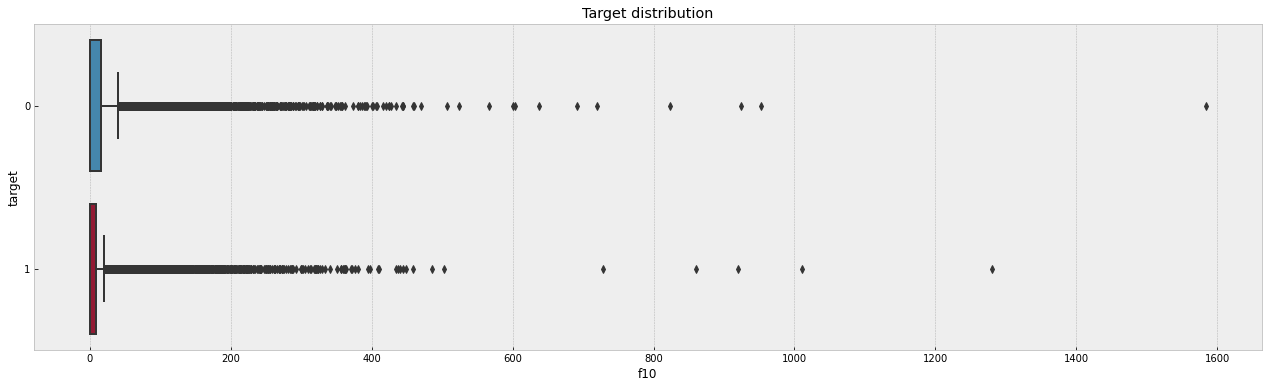

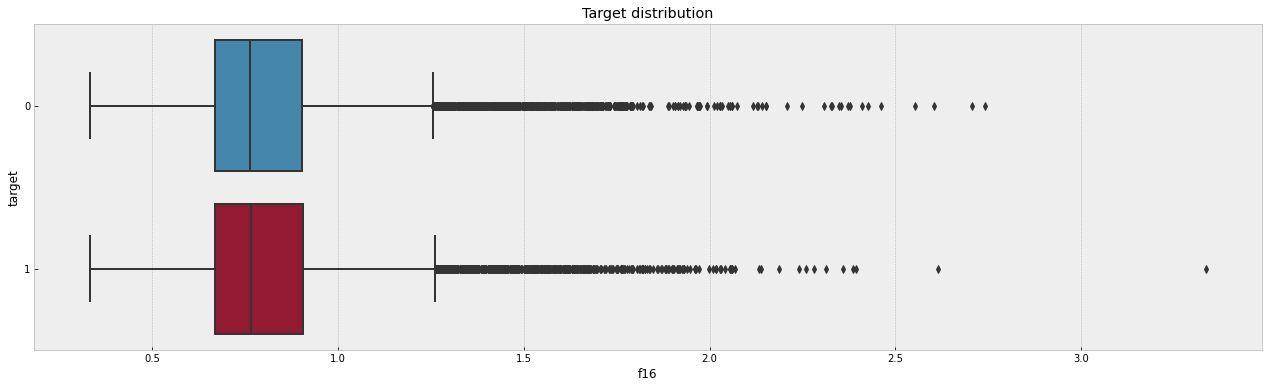

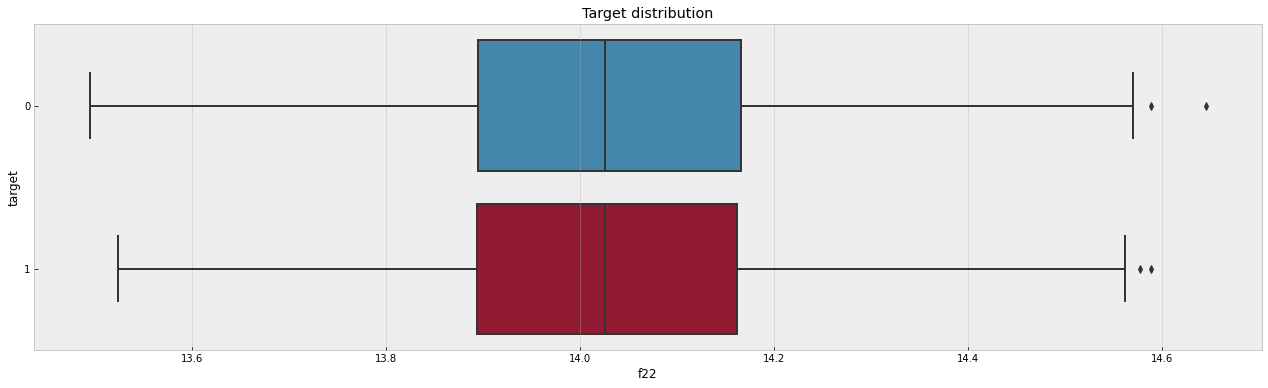

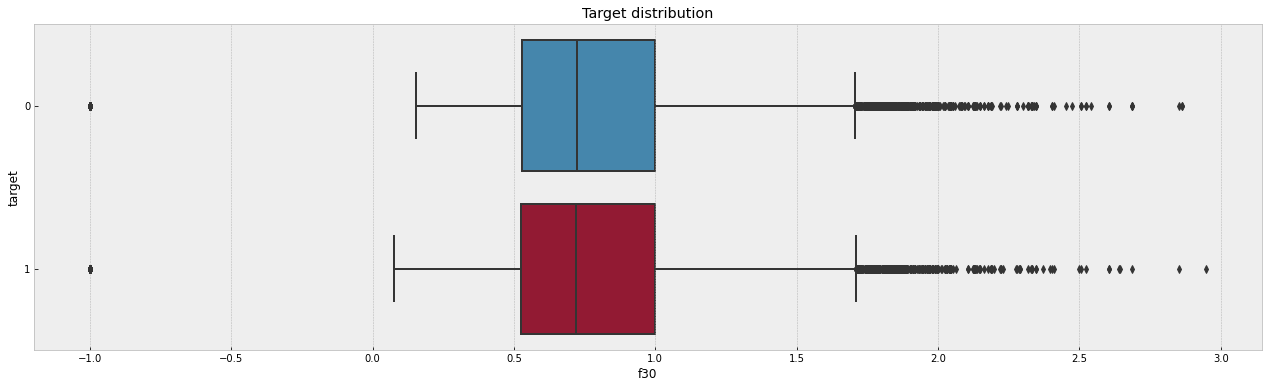

In [152]:
for col in df[cont_cols]:
    plt.figure(figsize=(22,6))
    plt.title('Target distribution')
    ax = sns.boxplot(x=df_orig_with_target[col], y=df_orig_with_target.target, orient='h')    
    plt.show()

# 2. Data Preprocessing

## 2.1 Handle missing values
As we have seen from our EDA, missing data is a large issue for our dataset.
There are several approaches for handling missing values. In the method chosen for this, we distinguish between continuous and discrete features. 

##### For continuous features we consider the following methods:
- Mean/Median Imputation
- K-nearest neighbours Imputation
    - Each sample’s missing values are imputed using the mean value from n_neighbors nearest neighbors found in the training set. Two samples are close if the features that neither is missing are close.
- Iterative Imputation (MICE: Multivariate Imputation by Chained Equations)
    - In Iterative Imputation each variable to be filled with missing values are treated as the dependent variable in a regression, with the other remaining variables as its predictors. It cycles through these models, fitting each in turn, then samples from the gaussian predictive posterior of the fitted estimator for each imputation [(2)](https://www.statsmodels.org/stable/imputation.html) [(3)](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html#sklearn.impute.IterativeImputer).

##### And for discrete features we consider the following methods:
- Frequent Categorical Imputation
    - Each nan value gets replaced with the most frequent value for that feature.
- Predictive
    - For each feature, a classifier is trained using the other features. This classifier then predicts the nan values for that particular feature.
    
We also try using an extra column for each feature, which tells which values for that feature that was originally a NaN value and has been filled in. The argument here is that this makes it possible for the model to weight non-imputed and imputed observations differently. 

#### Choose imputation combination
Later on we try out different combinations of these imputations in order to pick the combination that works best. 

#### Continuous features
We start by filling in missing values for the continuous features. First we show why it is usually better to apply more sophisticated methods than a simple mean imputation. Let's use 'f22' as an example.

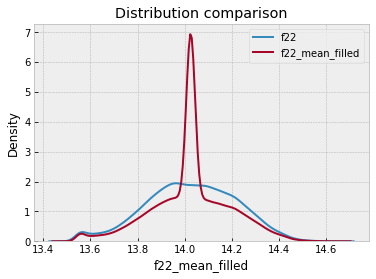

In [40]:
mean_imputation_df = df.copy()
feat = 'f22'
mean_imputation_df['f22_mean_filled'] = mean_imputation_df[feat].fillna(df[feat].mean())

sns.distplot(mean_imputation_df[feat], hist=False, label=feat)
sns.distplot(mean_imputation_df['f22_mean_filled'], hist=False, label='f22_mean_filled')
plt.legend()
plt.title('Distribution comparison');

We observe that left and right side are reasonably close, but there is a significant difference in distributions is in the center, because mean imputation will just set all missing values to the mean. Now we will use Multivariate Imputation for comparison.

In [ ]:
# imputed = mice(df[cont_cols].values)
start = time.time()
mice_imputation_df = df.copy()
imp = IterativeImputer(max_iter=10, random_state=0, 
                       sample_posterior=True, n_nearest_features=3)
imputed = imp.fit_transform(mice_imputation_df[numerical_features])
print(f'Imputed after {int(time.time()-start)}s')

In [ ]:
idx = mice_imputation_df[numerical_features].columns.tolist().index('f22')
mice_f22 = imputed[:, idx]
sns.distplot(mice_f22, hist=False, label='f22_mice_filled')
sns.distplot(mice_imputation_df[feat], hist=False, label=feat)
plt.legend()
plt.title('Distribution comparison');

We observe that using the Iterative Imputer the distribution of the imputed values is much closer to the original distribution. Let's make a general general method for this. 

In [48]:
def impute_continuous_features(df, target_feature_names, pretrained_imp=None, method='mice', add_nan_columns=True, verbose=True):
    """
    Args:
        - target_feature_names: the features to fill in NaN values for
        - method: the imputation method to use
    """

    start = time.time()
    df2 = df.copy()
    
    discrete_cols, cont_cols = get_discrete_and_continuous_feature(df2)    
    feature_df = df2.select_dtypes('float64')

    if pretrained_imp is not None:
        imputed = pretrained_imp.transform(feature_df)
        for feat in target_feature_names:
            idx = feature_df.columns.tolist().index(feat)
            if add_nan_columns:
                df2[f"{feat}_Imputed"] = np.where(df2[feat].isnull(), 1, 0)
            df2[feat] = imputed[:, idx]
        return imp, df2
    
    if method == 'mice':
        imp = IterativeImputer(max_iter=10, 
                               sample_posterior=True)
        #feature_df = df2.copy()
        #feature_df[discrete_cols] =  feature_df[discrete_cols].apply(lambda x: pd.factorize(x)[0])# pd.factorize(feature_df[discrete_cols]) # feature_df[discrete_cols].fillna(0)
        imputed = imp.fit_transform(feature_df)

    elif method == 'knn':
        imp = KNNImputer(n_neighbors=2, weights="uniform")
        imputed = imp.fit_transform(feature_df)
        
    elif method == 'mean':
        imp = SimpleImputer(strategy='mean')
        imputed = imp.fit_transform(feature_df)
    
    elif method == 'median':
        imp = SimpleImputer(strategy='median')
        imputed = imp.fit_transform(feature_df)
    
    for feat in target_feature_names:
        idx = feature_df.columns.tolist().index(feat)
        if add_nan_columns:
            df2[f"{feat}_Imputed"] = np.where(df2[feat].isnull(), 1, 0)
        df2[feat] = imputed[:, idx]
    
    if verbose:
        print(f'Imputation done after {int(time.time()-start)}s')
    return imp, df2

Let's compare each imputation method for all the continuous features.

In [51]:
feature_df = df.select_dtypes('float64')
#imp, df_imputed_mean = impute_continuous_features(df, cont_cols, method='mean')
#imp, df_imputed_median = impute_continuous_features(df, cont_cols, method='median')
imp, df_imputed_knn = impute_continuous_features(df, cont_cols, method='knn')
#imp, df_imputed_mice = impute_continuous_features(df, cont_cols, method='mice')

Imputation done after 333s


In [52]:
def plot_imputations(df, df_imputed, cont_cols):
    fig, ax = plt.subplots(2, 3, figsize=(20, 7))
    for variable, subplot in zip(cont_cols, ax.flatten()):
        sns.distplot(df[variable], hist=False, label='Without nan', ax=subplot)
        sns.distplot(df_imputed[variable], hist=False, label=f'Filled', ax=subplot)
        subplot.set_yticks([])
        subplot.legend()

#### Mean Imputer

In [ ]:
plot_imputations(df, df_imputed_mean, cont_cols)

#### Median Imputer

In [ ]:
plot_imputations(df, df_imputed_median, cont_cols)

#### KNN Imputer

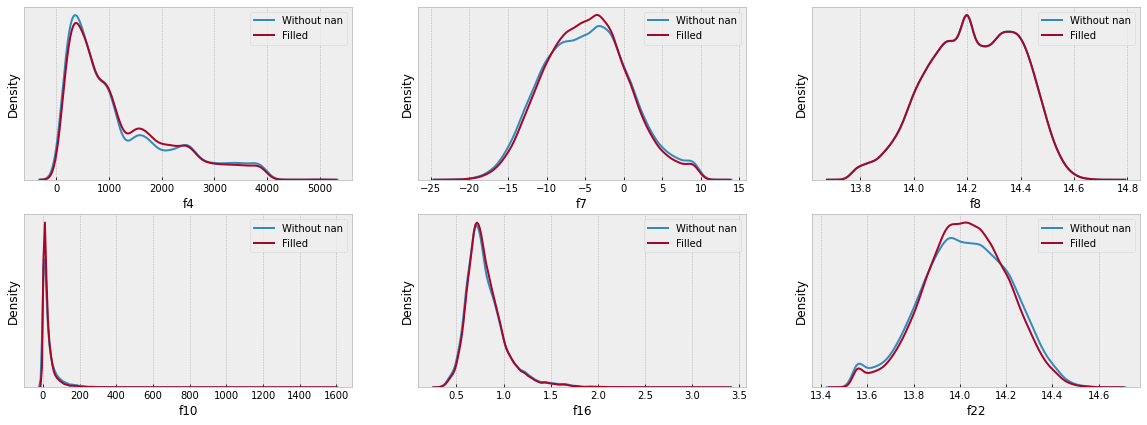

In [53]:
plot_imputations(df, df_imputed_knn, cont_cols)

#### MICE Imputer

In [ ]:
plot_imputations(df, df_imputed_mice, cont_cols)

We observe that the KNN Imputer and the Iterative Imputer (MICE) works best. However, we see that MICE can produce values that are quite far away from any value present in the actual data (due to the estimators being a linear regression model), while using KNN overcomes this issue. Thus, we choose the KNN imputer as our imputer for continuous values.

#### Discrete features
We create a method for imputing discrete features, and then compare the 'most frequent category imputer' to the 'predictive imputer'.

In [54]:
def impute_discrete_features(df, target_feature_names, method='predictive', add_nan_columns=True, verbose=True):
    """
    Args:
        - feature_df: feature_df that the imputer will be fit on 
        - target_feature_names: the features to fill in NaN values for
    """
    start = time.time()
    df2 = df.copy()
    
    if method == 'most_freq':
        imp = SimpleImputer(strategy='most_frequent')
        imputed = imp.fit_transform(df[target_feature_names])
        for i, c in enumerate(target_feature_names):
            if add_nan_columns:
                df2[f"{c}_Imputed"] = np.where(df2[c].isnull(), 1, 0)
            df2[c] = imputed[:, i]
            
    elif method == 'predictive':
        for feat in target_feature_names:
            #print(feat)
            clf = DecisionTreeClassifier()
            filtered_df = df2[df2[feat].notnull()]
            train_x = filtered_df.drop(columns=[feat])
            for c in train_x.select_dtypes('object').columns:
                le = LabelEncoder()
                encoded_data = le.fit_transform(train_x[c].astype(str))
                train_x[c] = encoded_data

            train_x.fillna(0, inplace=True)
            train_y = filtered_df[feat]
            clf.fit(train_x, train_y)

            filtered_df = df2[df2[feat].isnull()]
            x = filtered_df.drop(columns=[feat])
            for c in x.select_dtypes('object').columns:
                le = LabelEncoder()
                encoded_data = le.fit_transform(x[c].astype(str))
                x[c] = encoded_data
            x.fillna(0, inplace=True)
            
            #x = pd.get_dummies(x)
            y_hat = clf.predict(x)
            
            nan_idxs = df2[df2[feat].isnull()].index
            if add_nan_columns:
                df2[f"{feat}_Imputed"] = np.where(df2[feat].isnull(), 1, 0)
            
            df2.loc[nan_idxs, feat] = y_hat
           
            imp = clf
    if verbose:       
        print(f'Imputation done after {int(time.time()-start)}s')
    return imp, df2

In [58]:
#_, df_imputed_mf = impute_discrete_features(df_imputed_mice, discrete_cols, method='most_freq')
_, df_imputed_pred = impute_discrete_features(df_imputed_knn, discrete_cols)

Imputation done after 13s


In [59]:
def plot_discrete_imputations(df, df_imputed, disc_cols, n=5):
    disc_cols = disc_cols[:n]
    fig, ax = plt.subplots(n, 2, figsize=(12, 8))
    ax[0][0].set_title('Without nan')
    ax[0][1].set_title('Filled')
    for i, variable in enumerate(disc_cols):
        sns.countplot(df[variable], ax=ax[i][0])
        sns.countplot(df_imputed[variable], ax=ax[i][1])


Let's compare the distributions (counts) of values, for different features, when using the Frequent Categorical Imputer and the Predictive Imputer.

##### Frequent Categorical Imputer Count Plots

In [ ]:
plot_discrete_imputations(df, df_imputed_mf, discrete_cols, n=3)

##### Predictive Imputer Count Plots

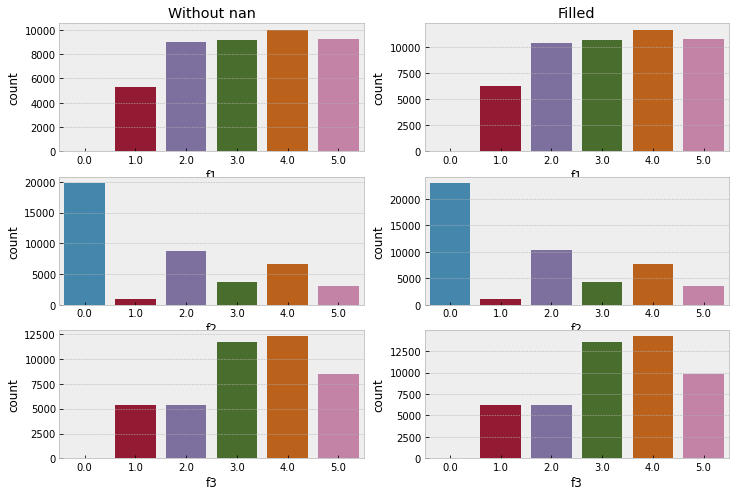

In [60]:
plot_discrete_imputations(df, df_imputed_pred, discrete_cols, n=3)

We observe that for the former, the distributions are not very similar. Due to the nature of the Categorical Frequency Imputer, only the count of the value that originally had the highest frequency has increased, while the rest stays the same. However, for the Predictive Imputer, the distribution stays almost identical, and the counts are spread more evenly among the values. Therefore, we choose this as our imputer for the discrete variables. 

Now, all the nan values should be filled:

In [61]:
df_clean = df_imputed_pred.copy()
print(f'# of nans in data: {sum(df_clean.isna().sum().values)}')
df_clean.head()

# of nans in data: 0


,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f18_Imputed,f19_Imputed,f20_Imputed,f21_Imputed,f23_Imputed,f24_Imputed,f25_Imputed,f26_Imputed,f27_Imputed,f29_Imputed
0,5.0,0.0,4.0,3598.0,M,3.0,-7.2430,13.9681,3.0,12.0,...,0,0,0,0,0,1,0,0,0,0
1,5.0,4.0,4.0,2072.0,M,4.0,-1.6662,14.0242,0.0,32.5,...,0,0,0,0,0,0,1,0,0,0
2,1.0,4.0,2.0,862.0,M,3.0,-0.1200,14.2174,0.0,32.0,...,0,0,0,1,0,0,0,0,0,0
3,2.0,2.0,1.0,409.0,F,5.0,-16.2169,13.8536,0.0,12.5,...,1,0,0,0,0,0,0,0,0,0
4,5.0,0.0,3.0,222.0,F,5.0,-8.1088,14.2347,0.0,31.5,...,0,1,0,0,0,0,1,0,0,0


## 2.2 Feature Encoding

For the discrete features, we have options of one-hot encoding and ordinal encoding. 
For the continuous features, we don't do anything, except scaling (normalization/standardization).

In [62]:
def one_hot_encode(df, columns):
    df2 = df.copy()
        
    for col in columns:
        if col in df2.columns:
            df2 = pd.concat([df2, pd.get_dummies(df2[col], drop_first=True, prefix=col)],axis=1)
            df2.drop(columns=[col], inplace=True)
    
    return df2

def ordinal_encode(df, columns, pretrained_enc=None):
    df2 = df.copy()        
    
    if pretrained_enc is not None:
        df2 = enc.transform(df2)
    else:
        enc = OrdinalEncoder()
        #df2 = enc.fit_transform(df2)
        for col in columns:
            if col in df2.columns:
                enc = OrdinalEncoder()
                df2[[col]] = enc.fit_transform(df2[[col]])
    
    return enc, df2


Let's combine every preprocess step into one preprocessing function:

In [63]:
def process(df_train_orig, df_test_orig=None, cont_imp_meth='knn', disc_imp_meth='predictive', encoder_meth='ordinal', add_nan_columns=True, verbose=True):
    df_train = df_train_orig.copy()
    if verbose:
        print(f'Train data has {df_train.shape[0]} rows, each with {df_train.shape[1]} features.')
    
    if df_test_orig is not None:
        df_test = df_test_orig.copy()
        print(f'Test data has {df_test.shape[0]} rows, each with {df_test.shape[1]} features.')
    
    train_ids = df_train['id']
    test_ids = None
    if df_test_orig is not None:
        test_ids = df_test[['id']]
    
    train_target = df_train['target']
    
    df_train.drop(columns=['id', 'target', 'f12', 'f28'], inplace=True)
    if df_test_orig is not None:
        df_test.drop(columns=['id', 'f12', 'f28'], inplace=True)

    # Find columns with too many nans, drop from train and test 
    #drop_cols = get_features_with_nan(df_train, thresh=0.3)
    #df_train.drop(columns=drop_cols, inplace=True)
    #if df_test_orig is not None:
     #   df_test.drop(columns=drop_cols, inplace=True)
    
    # Get numerical and non- numerical features
    numerical_features = [c for c in df_train.columns if df_train[c].dtype == 'float64']
    non_numerical_features = [c for c in df_train.columns if df_train[c].dtype == 'object']
    
    # Replace -1 and 0 with NaN for f30 and f10, respectively
    df_train = replace_with(df_train, 'f30', -1)
    df_train = replace_with(df_train, 'f10', 0)
    
    if df_test_orig is not None:
        df_test = replace_with(df_test, 'f30', -1)
        df_test = replace_with(df_test, 'f10', 0)
    
    # Drop because of high correlation with f10
    df_train.drop(columns=['f14'], inplace=True)
    if df_test_orig is not None:
        df_test.drop(columns=['f14'], inplace=True)
    
    numerical_features.remove('f14')
    
    discrete_cols, cont_cols = get_discrete_and_continuous_feature(df_train)
        
    # Impute missing values
    # Imputer is learned over both train and test if test is available
    if df_test_orig is not None:
        #df_train['is_train'] = 1
        #df_test['is_train'] = 0
        df_all = pd.concat([df_train, df_test]).reset_index(drop=True)
    else:
        df_all = df_train

    imp_cont, df_all_imputed = impute_continuous_features(df_all, cont_cols, 
                                                          method=cont_imp_meth, 
                                                          add_nan_columns=add_nan_columns,
                                                          verbose=verbose)
    imp_disc, df_all_imputed = impute_discrete_features(df_all_imputed, discrete_cols, 
                                                        method=disc_imp_meth,
                                                        add_nan_columns=add_nan_columns,
                                                        verbose=verbose)    
    df_all_clean = df_all_imputed

    # Encode features
    if encoder_meth == 'one_hot':
        df_all_clean_encoded = one_hot_encode(df_all_clean, discrete_cols)
    else:
        _, df_all_clean_encoded = ordinal_encode(df_all_clean, discrete_cols)
    
    # display(df_all_clean_encoded.head())
    # Seperate back to train and test
    if df_test_orig is not None:
        #train_df_clean_encoded = df_all_clean_encoded.loc[df_all_clean_encoded['is_train'] == 1]
        #test_df_clean_encoded = df_all_clean_encoded.loc[df_all_clean_encoded['is_train'] == 0]
        train_df_clean_encoded = df_all_clean_encoded.iloc[:df_train.shape[0], :].reset_index(drop=True)
        test_df_clean_encoded = df_all_clean_encoded.iloc[df_train.shape[0]:, :].reset_index(drop=True)
    else:
        train_df_clean_encoded = df_all_clean_encoded
        test_df_clean_encoded = None
    
    info = {}
    info['train_ids'] = train_ids
    info['test_ids'] = train_ids    
    info['discrete_cols'] = discrete_cols
    info['cont_cols'] = cont_cols
    info['numerical_features'] = numerical_features
    info['non_numerical_features'] = non_numerical_features
    
    if verbose:
        print(f'-- Done processing.')
    
    return train_df_clean_encoded, train_target, test_df_clean_encoded, info


## 2.3 Picking the best Imputation Combination
Now we use multiple baseline models in order to choose the best combination of imputation techniques. We try different combinations of the following: 

1. Continuous Imputation method
    - Mean
    - MICE
    - KNN
2. Discrete Imputation method:
    - Most frequent method
    - Predictive method
3. Include nan-capturing columns
    - Yes
    - No

In [64]:
def evaluate(models, x_train, x_val, y_train, y_val):
    roc_auc_total = 0
    nll_total = 0
    for model in models:
        try:
            model.fit(x_train, y_train, verbose=0)
        except:
            model.fit(x_train, y_train)
        y_hat_probs = model.predict_proba(x_val)
        roc_auc_total += roc_auc_score(y_val, y_hat_probs[:, 1])
        
    return roc_auc_total/len(models)
    

In [65]:
def evaluate_imputation_combinations(df_orig, fixed):
    
    cont_imp_methods = fixed['cont_imp_method'] if fixed['cont_imp_method'] else ['mean', 'knn', 'mice']
    disc_imp_methods = fixed['disc_imp_method'] if fixed['disc_imp_method'] else ['most_freq', 'predictive']
    add_nan_columns = fixed['add_nan_columns'] if fixed['add_nan_columns'] else [False, True]
    
    # Because KNN and MICE is rather time-consuming, we will fix the continuous imputation method to be 'mean',
    # when evaluating the three other steps
    for cont_imp_method in cont_imp_methods:
        for disc_imp_method in disc_imp_methods:
            for add in add_nan_columns:
                df_train_processed, train_target, _, _ = process(df_train_orig, df_test_orig=None,
                                                                 cont_imp_meth=cont_imp_method, 
                                                                 disc_imp_meth=disc_imp_method,        
                                                                 add_nan_columns=add,
                                                                 verbose=False)


                x_train, x_val, y_train, y_val = train_test_split(df_train_processed, train_target, test_size=0.2)

                models = [LogisticRegression(max_iter=100), CatBoostClassifier(), XGBClassifier()] 
                roc_auc = evaluate(models, x_train, x_val, y_train, y_val)
                print('-'*50)
                print(f'Cont Imp method: {cont_imp_method}')
                print(f'Discrete Imp method: {disc_imp_method}')
                print(f'Add nan columns: {add}')
                print(f'\t -- ROC-AUC: {roc_auc:.3f}')
                 

In [66]:
df_train_orig = pd.read_csv("data/challenge3_train.csv")
fixed = {
    'cont_imp_method': ['mean'],
    'disc_imp_method': None,
    'add_nan_columns': None
}
evaluate_imputation_combinations(df_train_orig, fixed)

Learning rate set to 0.049775
0:	learn: 0.6755359	total: 23.8ms	remaining: 23.8s
1:	learn: 0.6599485	total: 44.2ms	remaining: 22.1s
2:	learn: 0.6470385	total: 61ms	remaining: 20.3s
3:	learn: 0.6362593	total: 78.9ms	remaining: 19.6s
4:	learn: 0.6256461	total: 95.5ms	remaining: 19s
5:	learn: 0.6147538	total: 106ms	remaining: 17.5s
6:	learn: 0.6063363	total: 115ms	remaining: 16.4s
7:	learn: 0.5975429	total: 126ms	remaining: 15.6s
8:	learn: 0.5901659	total: 136ms	remaining: 14.9s
9:	learn: 0.5838257	total: 146ms	remaining: 14.4s
10:	learn: 0.5756187	total: 155ms	remaining: 14s
11:	learn: 0.5684142	total: 171ms	remaining: 14.1s
12:	learn: 0.5633041	total: 181ms	remaining: 13.8s
13:	learn: 0.5555968	total: 191ms	remaining: 13.4s
14:	learn: 0.5501848	total: 204ms	remaining: 13.4s
15:	learn: 0.5457853	total: 222ms	remaining: 13.6s
16:	learn: 0.5417558	total: 239ms	remaining: 13.8s
17:	learn: 0.5368016	total: 259ms	remaining: 14.1s
18:	learn: 0.5319757	total: 279ms	remaining: 14.4s
19:	learn: 0

160:	learn: 0.3944021	total: 2.03s	remaining: 10.6s
161:	learn: 0.3941248	total: 2.05s	remaining: 10.6s
162:	learn: 0.3938282	total: 2.06s	remaining: 10.6s
163:	learn: 0.3935650	total: 2.08s	remaining: 10.6s
164:	learn: 0.3931961	total: 2.09s	remaining: 10.6s
165:	learn: 0.3929898	total: 2.1s	remaining: 10.6s
166:	learn: 0.3927189	total: 2.11s	remaining: 10.5s
167:	learn: 0.3926087	total: 2.12s	remaining: 10.5s
168:	learn: 0.3921581	total: 2.13s	remaining: 10.5s
169:	learn: 0.3918903	total: 2.14s	remaining: 10.4s
170:	learn: 0.3915950	total: 2.15s	remaining: 10.4s
171:	learn: 0.3910070	total: 2.16s	remaining: 10.4s
172:	learn: 0.3907560	total: 2.17s	remaining: 10.4s
173:	learn: 0.3905720	total: 2.18s	remaining: 10.3s
174:	learn: 0.3901528	total: 2.19s	remaining: 10.3s
175:	learn: 0.3899723	total: 2.2s	remaining: 10.3s
176:	learn: 0.3898318	total: 2.21s	remaining: 10.3s
177:	learn: 0.3895255	total: 2.22s	remaining: 10.3s
178:	learn: 0.3892185	total: 2.23s	remaining: 10.2s
179:	learn: 0.

326:	learn: 0.3600400	total: 4.08s	remaining: 8.39s
327:	learn: 0.3598689	total: 4.09s	remaining: 8.39s
328:	learn: 0.3597352	total: 4.11s	remaining: 8.39s
329:	learn: 0.3595875	total: 4.12s	remaining: 8.37s
330:	learn: 0.3594677	total: 4.14s	remaining: 8.36s
331:	learn: 0.3592875	total: 4.15s	remaining: 8.35s
332:	learn: 0.3591187	total: 4.16s	remaining: 8.33s
333:	learn: 0.3590161	total: 4.17s	remaining: 8.31s
334:	learn: 0.3589189	total: 4.18s	remaining: 8.31s
335:	learn: 0.3587144	total: 4.2s	remaining: 8.29s
336:	learn: 0.3585829	total: 4.2s	remaining: 8.27s
337:	learn: 0.3583778	total: 4.21s	remaining: 8.26s
338:	learn: 0.3582035	total: 4.23s	remaining: 8.24s
339:	learn: 0.3580968	total: 4.24s	remaining: 8.23s
340:	learn: 0.3579635	total: 4.25s	remaining: 8.21s
341:	learn: 0.3578280	total: 4.26s	remaining: 8.2s
342:	learn: 0.3577280	total: 4.28s	remaining: 8.19s
343:	learn: 0.3575593	total: 4.29s	remaining: 8.19s
344:	learn: 0.3574205	total: 4.31s	remaining: 8.19s
345:	learn: 0.3

491:	learn: 0.3403756	total: 6.53s	remaining: 6.75s
492:	learn: 0.3402904	total: 6.55s	remaining: 6.73s
493:	learn: 0.3401754	total: 6.56s	remaining: 6.72s
494:	learn: 0.3401576	total: 6.57s	remaining: 6.7s
495:	learn: 0.3400966	total: 6.58s	remaining: 6.68s
496:	learn: 0.3400093	total: 6.59s	remaining: 6.67s
497:	learn: 0.3399101	total: 6.6s	remaining: 6.65s
498:	learn: 0.3398251	total: 6.61s	remaining: 6.64s
499:	learn: 0.3397269	total: 6.62s	remaining: 6.62s
500:	learn: 0.3396835	total: 6.64s	remaining: 6.61s
501:	learn: 0.3396142	total: 6.65s	remaining: 6.59s
502:	learn: 0.3394940	total: 6.66s	remaining: 6.58s
503:	learn: 0.3393796	total: 6.67s	remaining: 6.56s
504:	learn: 0.3392765	total: 6.68s	remaining: 6.55s
505:	learn: 0.3391494	total: 6.69s	remaining: 6.54s
506:	learn: 0.3390255	total: 6.7s	remaining: 6.52s
507:	learn: 0.3388833	total: 6.71s	remaining: 6.5s
508:	learn: 0.3387881	total: 6.72s	remaining: 6.49s
509:	learn: 0.3386943	total: 6.74s	remaining: 6.47s
510:	learn: 0.33

660:	learn: 0.3246332	total: 8.32s	remaining: 4.27s
661:	learn: 0.3245706	total: 8.33s	remaining: 4.25s
662:	learn: 0.3244828	total: 8.34s	remaining: 4.24s
663:	learn: 0.3244408	total: 8.35s	remaining: 4.23s
664:	learn: 0.3243490	total: 8.36s	remaining: 4.21s
665:	learn: 0.3242724	total: 8.37s	remaining: 4.2s
666:	learn: 0.3241810	total: 8.38s	remaining: 4.18s
667:	learn: 0.3240781	total: 8.39s	remaining: 4.17s
668:	learn: 0.3240150	total: 8.4s	remaining: 4.16s
669:	learn: 0.3239258	total: 8.41s	remaining: 4.14s
670:	learn: 0.3238553	total: 8.42s	remaining: 4.13s
671:	learn: 0.3238029	total: 8.43s	remaining: 4.12s
672:	learn: 0.3236904	total: 8.44s	remaining: 4.1s
673:	learn: 0.3235730	total: 8.45s	remaining: 4.09s
674:	learn: 0.3234772	total: 8.46s	remaining: 4.07s
675:	learn: 0.3233872	total: 8.47s	remaining: 4.06s
676:	learn: 0.3232950	total: 8.48s	remaining: 4.05s
677:	learn: 0.3232208	total: 8.49s	remaining: 4.03s
678:	learn: 0.3231343	total: 8.5s	remaining: 4.02s
679:	learn: 0.32

832:	learn: 0.3107163	total: 10.3s	remaining: 2.07s
833:	learn: 0.3106200	total: 10.3s	remaining: 2.06s
834:	learn: 0.3105581	total: 10.4s	remaining: 2.04s
835:	learn: 0.3104821	total: 10.4s	remaining: 2.03s
836:	learn: 0.3104139	total: 10.4s	remaining: 2.02s
837:	learn: 0.3103298	total: 10.4s	remaining: 2.01s
838:	learn: 0.3102412	total: 10.4s	remaining: 2s
839:	learn: 0.3101788	total: 10.4s	remaining: 1.98s
840:	learn: 0.3101291	total: 10.4s	remaining: 1.97s
841:	learn: 0.3100512	total: 10.4s	remaining: 1.96s
842:	learn: 0.3099872	total: 10.4s	remaining: 1.94s
843:	learn: 0.3099323	total: 10.5s	remaining: 1.93s
844:	learn: 0.3098671	total: 10.5s	remaining: 1.92s
845:	learn: 0.3097926	total: 10.5s	remaining: 1.91s
846:	learn: 0.3097215	total: 10.5s	remaining: 1.89s
847:	learn: 0.3096000	total: 10.5s	remaining: 1.88s
848:	learn: 0.3095517	total: 10.5s	remaining: 1.87s
849:	learn: 0.3094848	total: 10.5s	remaining: 1.86s
850:	learn: 0.3094213	total: 10.5s	remaining: 1.85s
851:	learn: 0.3

--------------------------------------------------
Cont Imp method: mean
Discrete Imp method: most_freq
Add nan columns: False
	 -- ROC-AUC: 0.862
--------------------------------------------------
Cont Imp method: mean
Discrete Imp method: most_freq
Add nan columns: True
	 -- ROC-AUC: 0.874
--------------------------------------------------
Cont Imp method: mean
Discrete Imp method: predictive
Add nan columns: False
	 -- ROC-AUC: 0.870
--------------------------------------------------
Cont Imp method: mean
Discrete Imp method: predictive
Add nan columns: True
	 -- ROC-AUC: 0.878


**Based on this, we choose the 'predictive' discrete imputation method, and we choose to add nan columns.
Now let's fix those, and compare between 'mean', 'mice' and 'knn' for the the continuous imputation method..**

In [67]:
fixed = {
    'cont_imp_method': None,
    'disc_imp_method': ['predictive'],
    'add_nan_columns': [True]
}
evaluate_imputation_combinations(df_train_orig, fixed)

--------------------------------------------------
Cont Imp method: mean
Discrete Imp method: predictive
Add nan columns: True
	 -- ROC-AUC: 0.877
--------------------------------------------------
Cont Imp method: knn
Discrete Imp method: predictive
Add nan columns: True
	 -- ROC-AUC: 0.870
--------------------------------------------------
Cont Imp method: mice
Discrete Imp method: predictive
Add nan columns: True
	 -- ROC-AUC: 0.874


**Based on this, we choose the 'knn' continuous imputation method.**

# 3. Model Choice and Training 
To choose between models, we perform k-fold cross-validation.

In [68]:
# Helper method
def get_model(name, params):
    if name == 'MLP':
        model = MLPClassifier(**params)
    elif name == 'SGD':
        model = SGDClassifier(**params)
    elif name == 'SVC':
        model = SVC(**params)
    elif name == 'LogReg':
        model = LogisticRegression(**params)
    elif name == 'GBoost':
        model = GradientBoostingClassifier(**params)
    elif name == 'XGBoost':
        model = XGBClassifier(**params)
    elif name == 'AdaBoost':
        model = AdaBoostClassifier(**params)
    elif name == 'RandomForest':
        model = RandomForestClassifier(**params)
    elif name == 'CatBoost':
        model = CatBoostClassifier(**params)
        
    return model

In [154]:
def compute_kfold_CV(df_train, targets, model, k=5, normalize=False, keras=False):
    X = df_train.copy()
    y = targets.copy()
    
    hist = {}
    hist['fold_acc'] = np.zeros((k,))
    hist['fold_f1'] = np.zeros((k,))
    hist['fold_roc_auc'] = np.zeros((k,))
    hist['fold_nll'] = np.zeros((k,))
    
    print(f'Starting {k}-fold CV..')
    kf = KFold(n_splits=k)
    for i, (train_index, val_index) in enumerate(kf.split(X)):
        #print("TRAIN:", train_index, "TEST:", val_index)
        x_train, x_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        if normalize:
            scaler = StandardScaler()
            x_train = scaler.fit_transform(train_x)
            x_val = scaler.fit_transform(val_x)
        
        try:
            model.fit(x_train, y_train, verbose=0)
        except:
            model.fit(x_train, y_train)
        
        

        y_hat = model.predict(x_val)
        if keras:
            y_hat_proba = y_hat
            y_hat = [np.round(y) for y in y_hat]
        else: 
            y_hat_proba = model.predict_proba(x_val)[:, 1]
        
        acc = accuracy_score(y_val, y_hat)
        f1 = f1_score(y_val, y_hat)
        roc_auc = roc_auc_score(y_val, y_hat_proba)
        nll = log_loss(y_val, y_hat_proba)
        
        hist['fold_acc'][i] = acc
        hist['fold_f1'][i] = f1
        hist['fold_roc_auc'][i] = roc_auc
        hist['fold_nll'][i] = nll
        
        print(f'Fold_{i+1} done')
    
    print('-- Done.')
    return hist
        

In [70]:
def plot_roc_auc(y_true, y_hat_probs):
    fpr, tpr, thresholds = roc_curve(y_true, y_hat_probs)
    plt.plot(fpr, tpr) 
    plt.axis("Square")
    plt.xlim([-0.05, 1.05]) 
    plt.ylim([-0.05, 1.05]) 
    plt.xlabel('False Positive Rate') 
    plt.ylabel('True Positive Rate') 
    plt.title('receiver operating characteristic curve: score=%f' % score) 
    plt.show()

In [71]:
def display_results(hist, plot=True):
    mean_acc = hist['fold_acc'].mean()
    mean_f1 = hist['fold_f1'].mean()
    mean_roc_auc = hist['fold_roc_auc'].mean()
    mean_nll = hist['fold_nll'].mean()

    print("Results:")
    print(f'\t Average fold accuracy: {mean_acc:.3f}')
    print(f'\t Average fold f1: {mean_f1:.3f}')
    print(f'\t Average fold roc_auc: {mean_roc_auc:.3f}')
    print(f'\t Average fold nll: {mean_nll:.3f}')


## 3.1 K-fold Cross-Validation on multiple models
We start by pre-processing the data in the optimal way found earlier. Then, for each model, we run a 5-fold cross-validation and evaluate each model using several metrics. Based on this, the best model is chosen.

In [ ]:
df_train_orig = pd.read_csv("data/challenge3_train.csv")
df_test_orig = pd.read_csv("data/challenge3_test.csv")
#display(df_train_orig)

df_train_processed, train_target, df_test_processed, info = process(df_train_orig, df_test_orig=None,
                                                    cont_imp_meth='knn', 
                                                    disc_imp_meth='predictive',
                                                    encoder_meth='ordinal')

#display(df_train_processed)
train_ids = info['train_ids']
test_ids = info['test_ids']
discrete_cols = info['discrete_cols']
cont_cols = info['cont_cols']
numerical_features = info['numerical_features']
non_numerical_features = info['non_numerical_features']

### CatBoostClassifier

In [74]:
 catboost_params = {
    'iterations': 500,
    'border_count': 50
}

model = CatBoostClassifier(catboost_params)
hist = compute_kfold_CV(df_train_processed, train_target, model, k=5)
display_results(hist)


Starting 5-fold CV..
Fold_1 done
Fold_2 done
Fold_3 done
Fold_4 done
Fold_5 done
-- Done.
Results:
	 Average fold accuracy: 0.847
	 Average fold f1: 0.818
	 Average fold roc_auc: 0.918
	 Average fold nll: 0.357


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

### Tuning hyperparameters

In [125]:
grid = {
    'depth': [6, 8, 10],
    'l2_leaf_reg': [3, 5, 7, 9],
    'iterations': [1000, 1250, 1500]
}


model = CatBoostClassifier()

randomized_search_result = model.randomized_search(grid,
                                                   X=df_train_processed,
                                                   y=train_target,
                                                   plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.3610353653
bestIteration = 998

0:	loss: 0.3610354	best: 0.3610354 (0)	total: 10.3s	remaining: 1m 32s

bestTest = 0.3588954748
bestIteration = 1246

1:	loss: 0.3588955	best: 0.3588955 (1)	total: 28s	remaining: 1m 51s

bestTest = 0.3579441489
bestIteration = 1499

2:	loss: 0.3579441	best: 0.3579441 (2)	total: 51s	remaining: 1m 59s

bestTest = 0.3556008922
bestIteration = 993

3:	loss: 0.3556009	best: 0.3556009 (3)	total: 1m 15s	remaining: 1m 52s

bestTest = 0.3555333156
bestIteration = 987

4:	loss: 0.3555333	best: 0.3555333 (4)	total: 1m 38s	remaining: 1m 38s

bestTest = 0.3542663047
bestIteration = 1230

5:	loss: 0.3542663	best: 0.3542663 (5)	total: 2m 10s	remaining: 1m 27s

bestTest = 0.3536823565
bestIteration = 1407

6:	loss: 0.3536824	best: 0.3536824 (6)	total: 2m 48s	remaining: 1m 12s

bestTest = 0.3538966596
bestIteration = 1400

7:	loss: 0.3538967	best: 0.3536824 (6)	total: 3m 29s	remaining: 52.4s

bestTest = 0.3533241052
bestIteration = 993

8:	loss: 0.3533241	be

In [128]:
best_params = randomized_search_result['params']
best_params

{'depth': 10, 'l2_leaf_reg': 9, 'iterations': 1000}

In [130]:
tuned_model = CatBoostClassifier(**best_params)
hist = compute_kfold_CV(df_train_processed, train_target, tuned_model, k=2)
display_results(hist)

Starting 2-fold CV..
Fold_1 done
Fold_2 done
-- Done.
Results:
	 Average fold accuracy: 0.842
	 Average fold f1: 0.810
	 Average fold roc_auc: 0.915
	 Average fold nll: 0.362
